**Instructions**

Getting the histogram for midline thal masks/clusters that made it to specific ROIs. We need bilateral masks ("#merging the bilateral masks") so as to avoid posterior thalamic features (ROIs). For 5 subjects. After that, look at which regions are consistently down/consistently up. If some regions are *sometimes down*, do not include them. Make sure you are considering anatomical connections. 

You should only run this once, and not rerun it again.

In [1]:
from sklearn.cluster import KMeans
import nibabel as nb
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from nilearn.plotting import plot_anat
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Check for subject 100307

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: get_data() is deprecated in favor of get_fdata(),

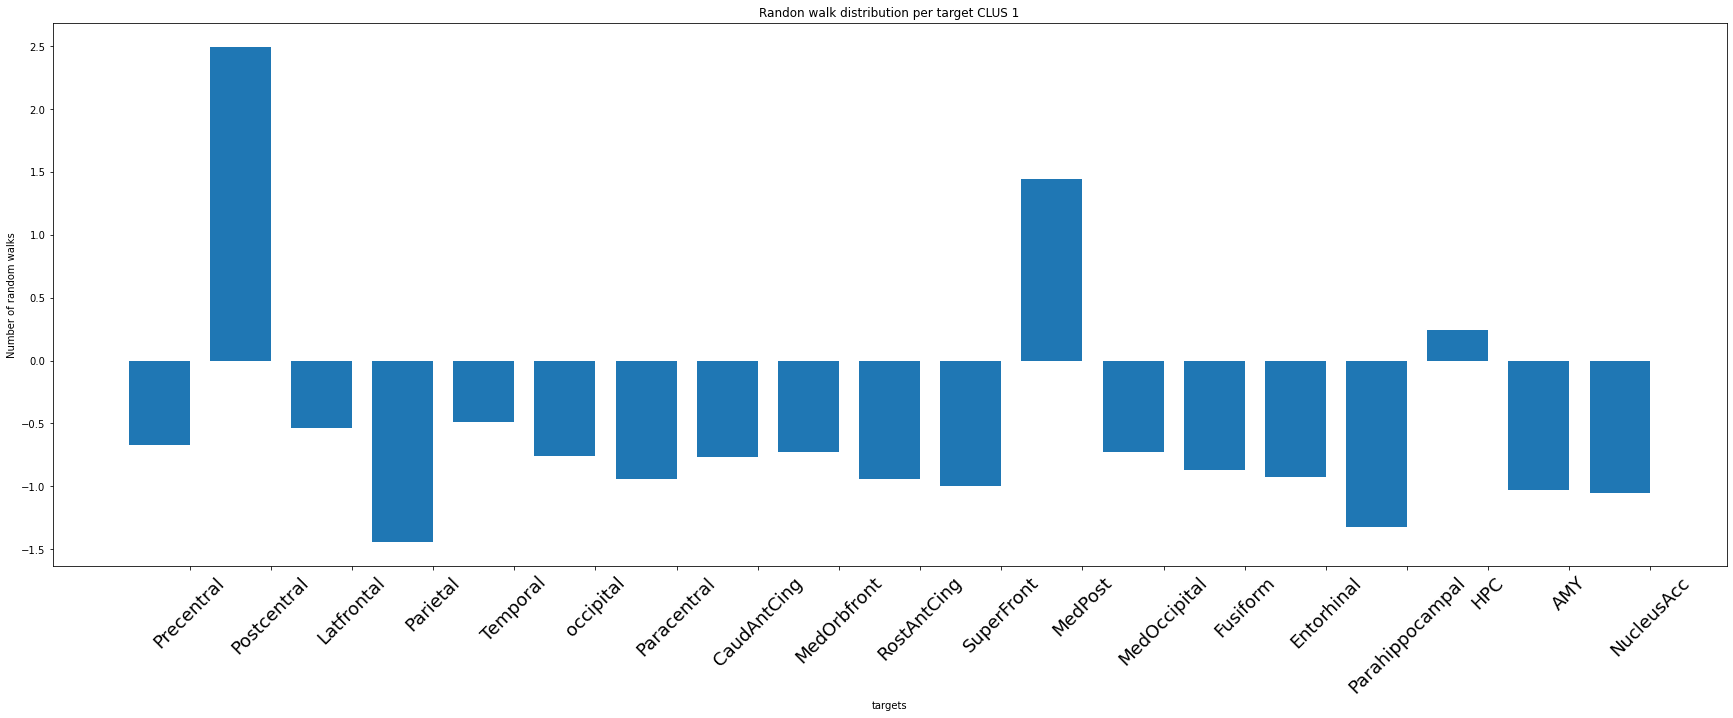

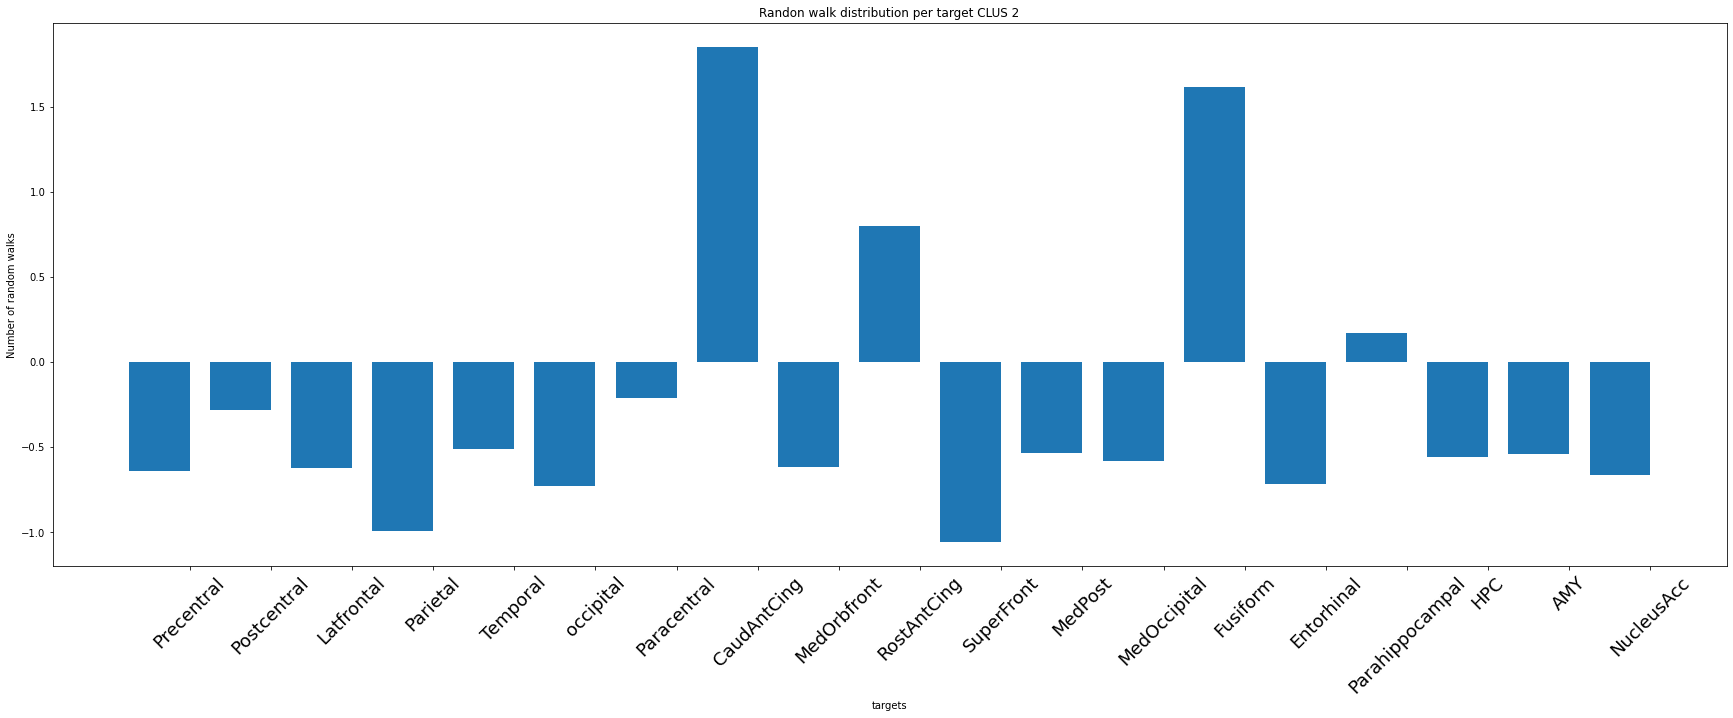

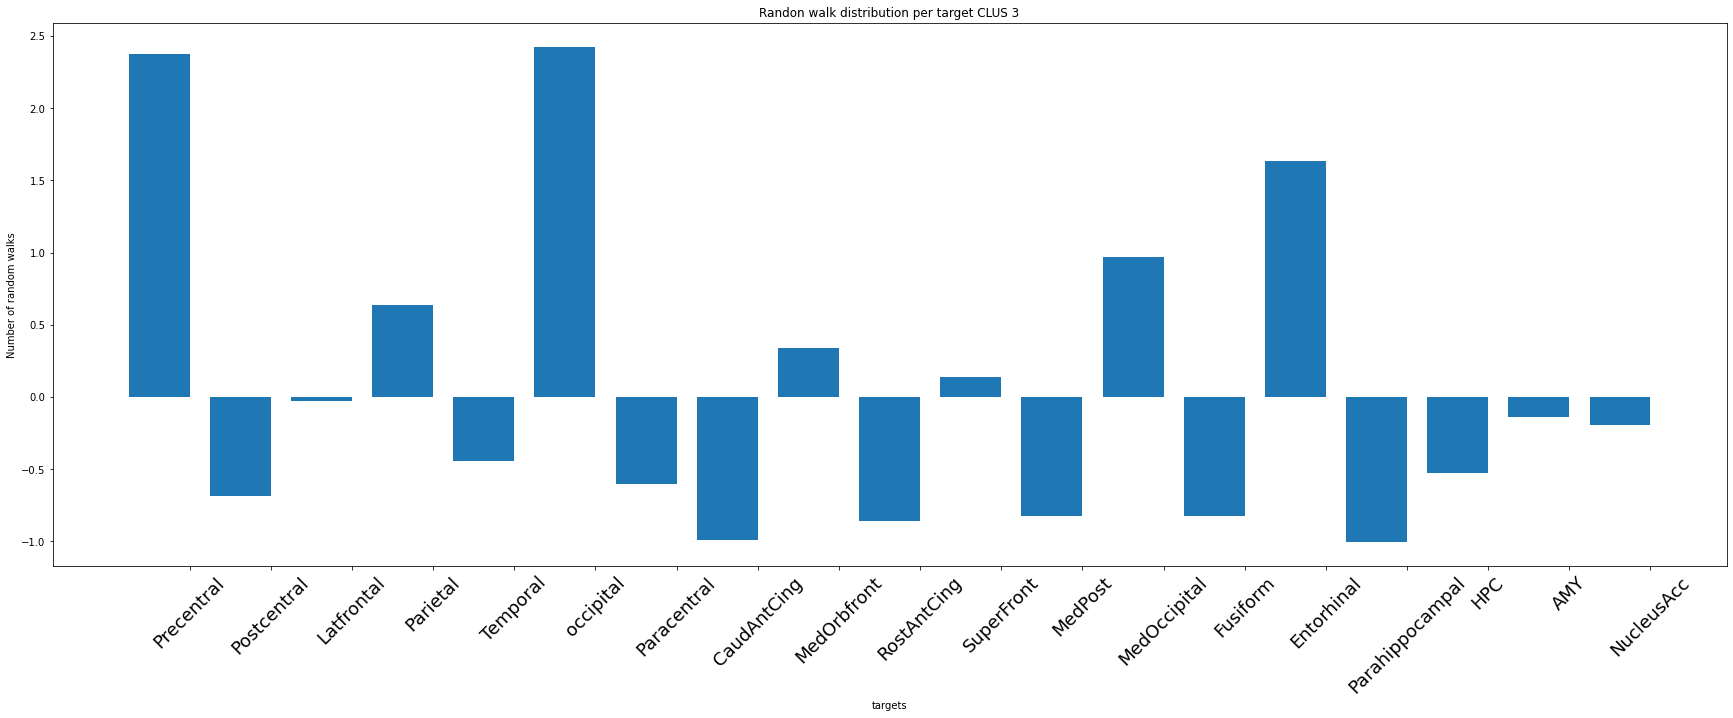

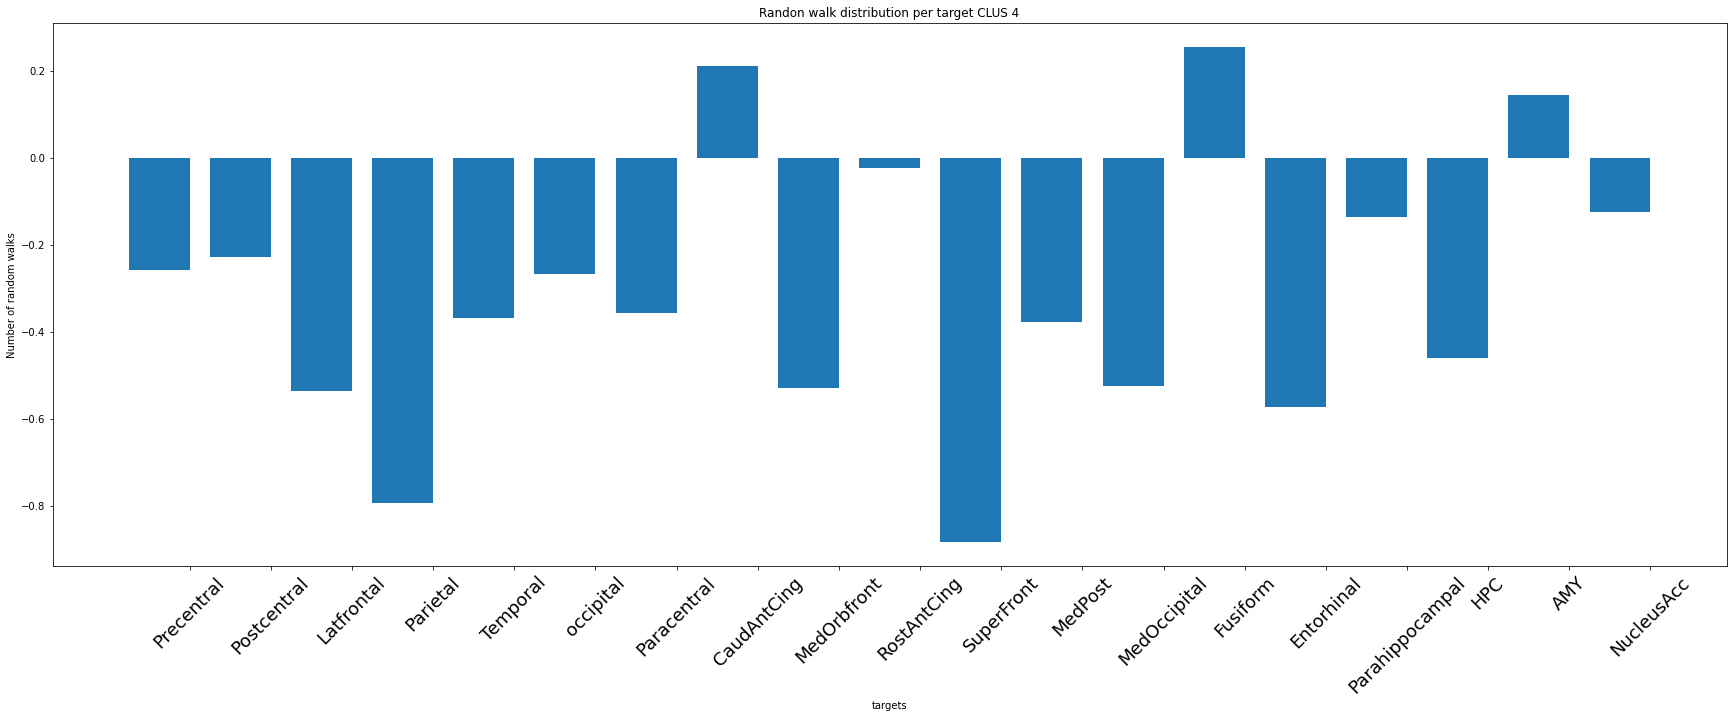

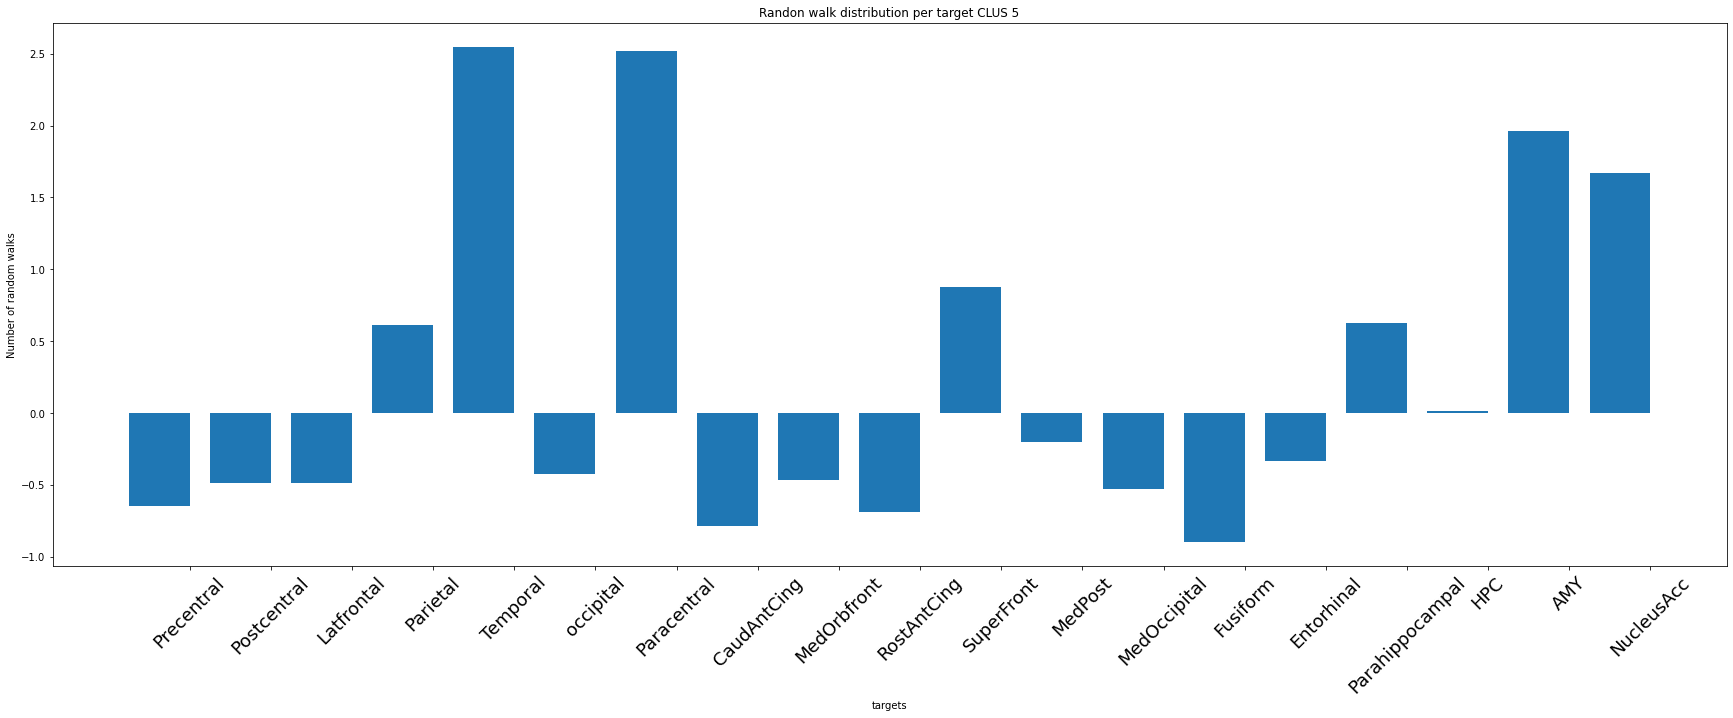

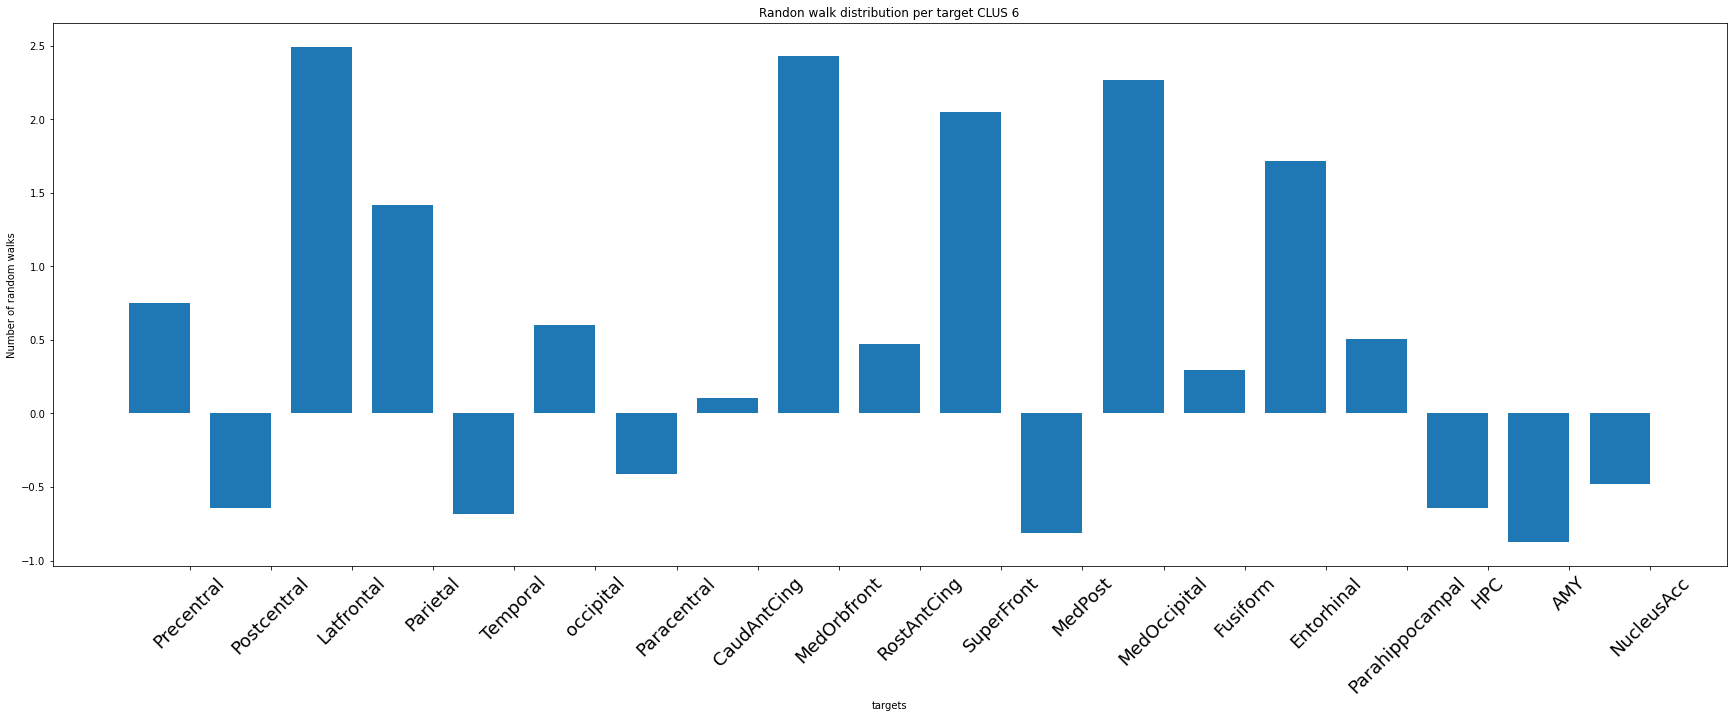

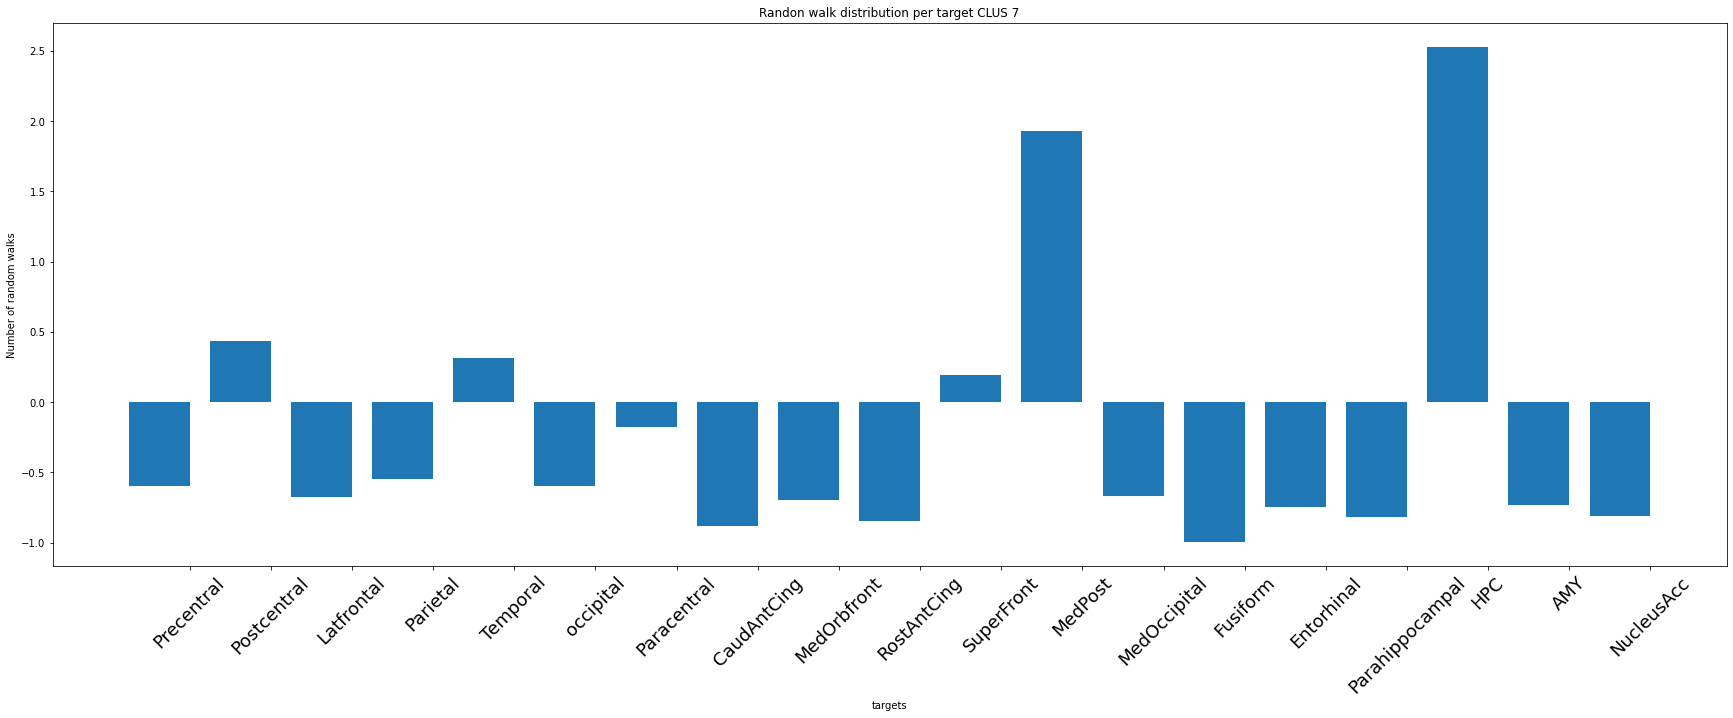

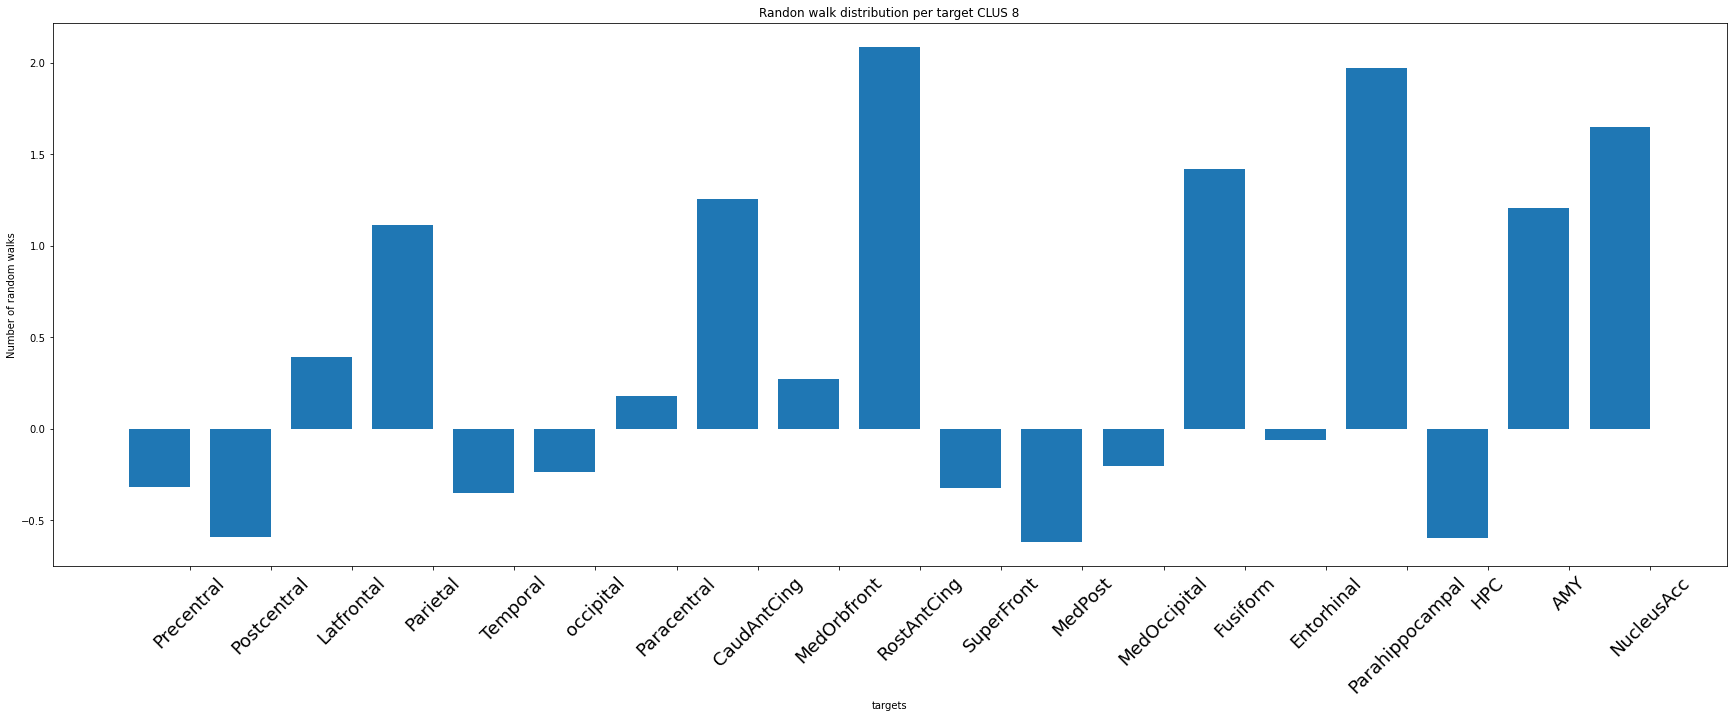

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


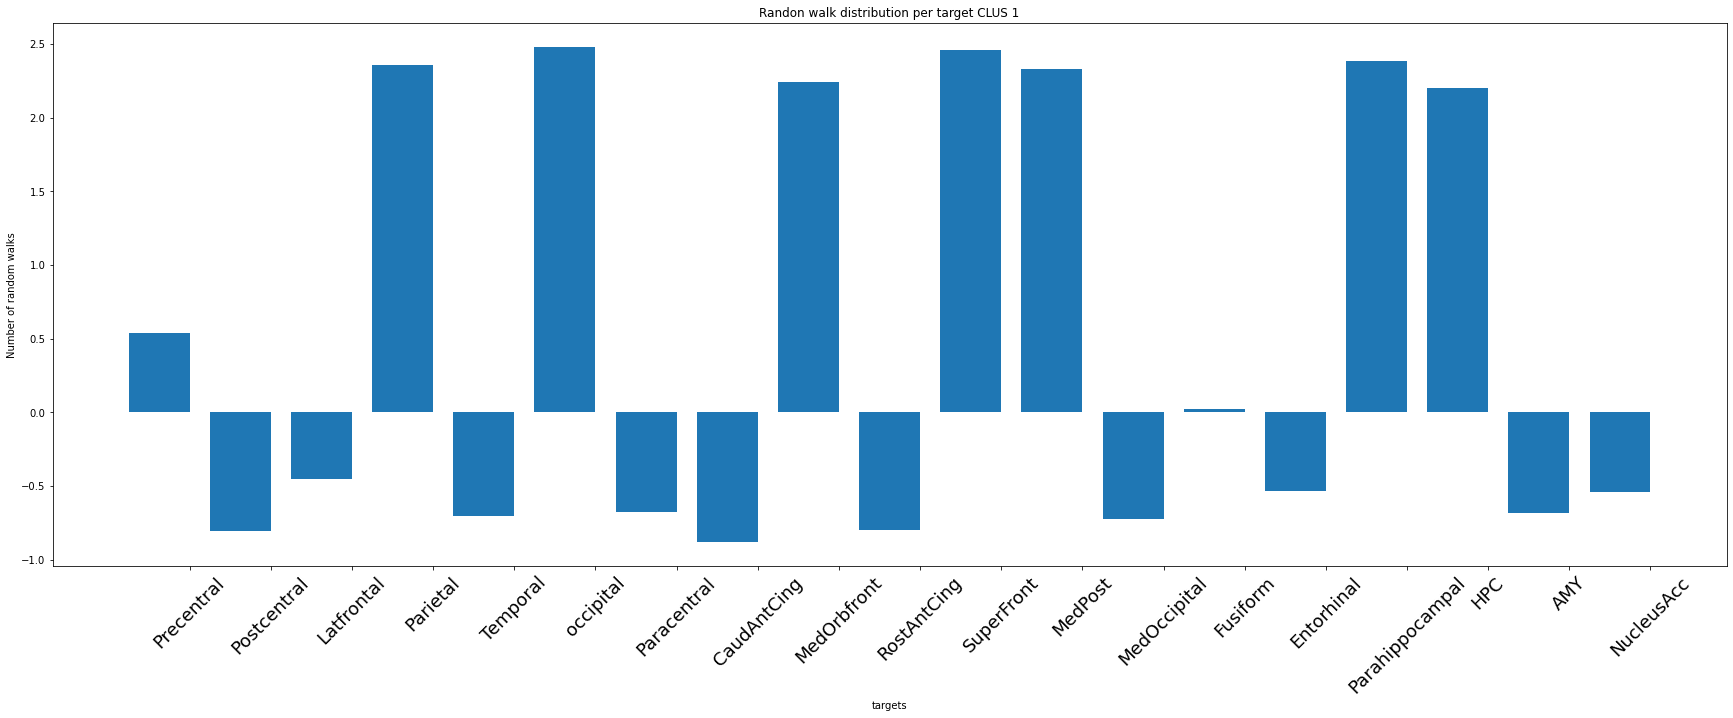

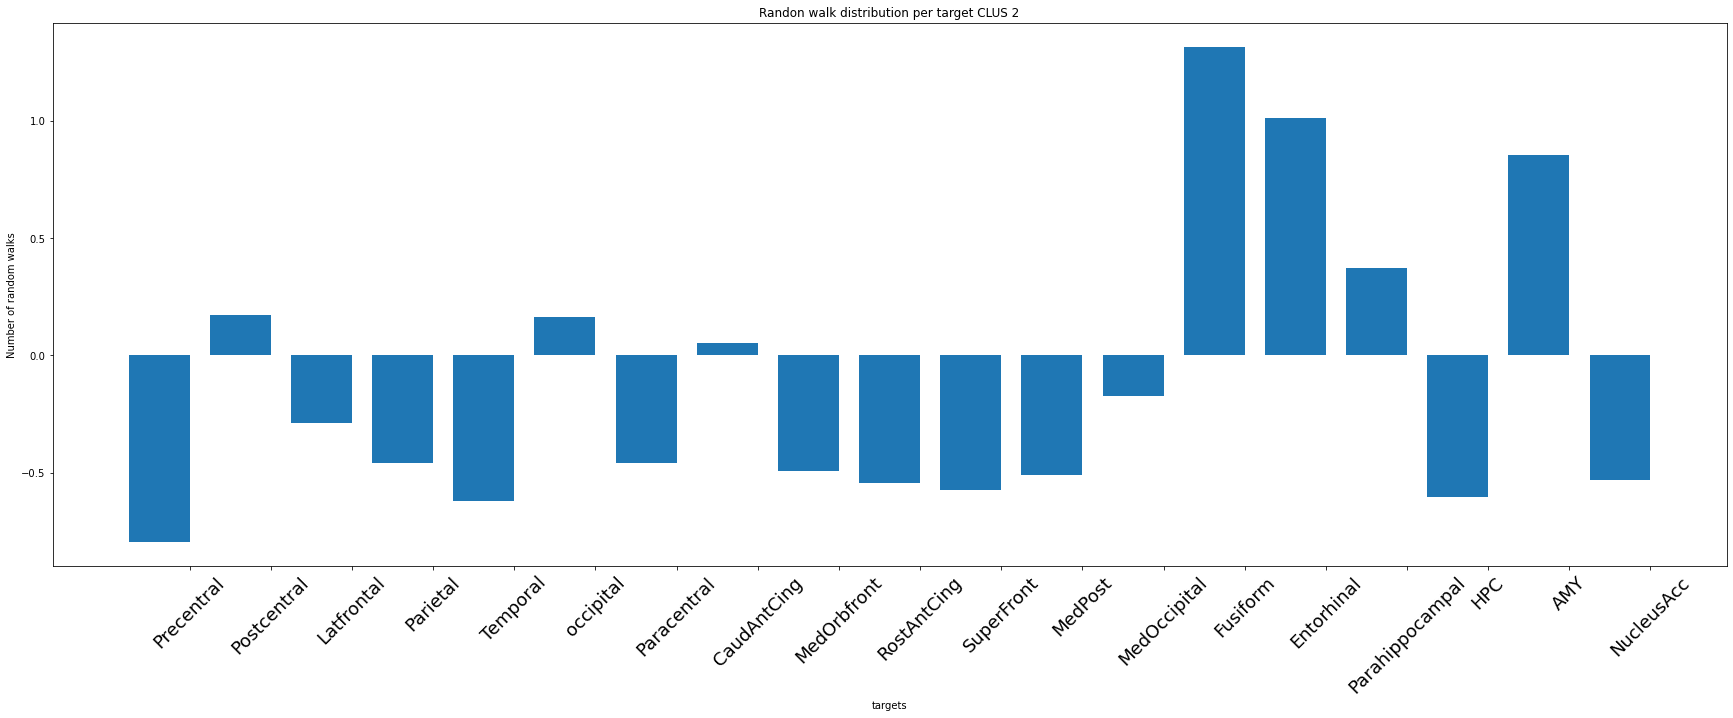

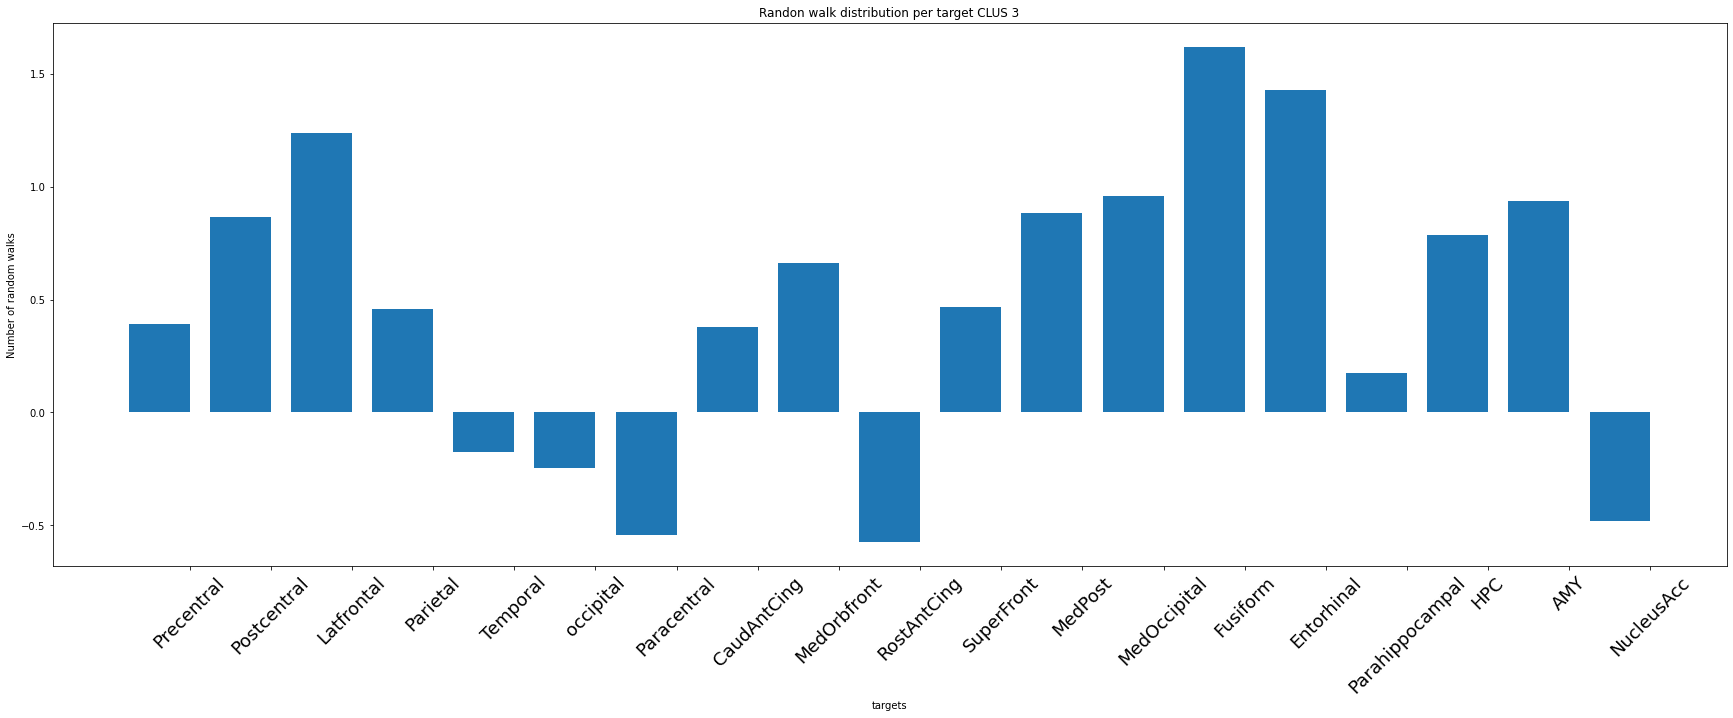

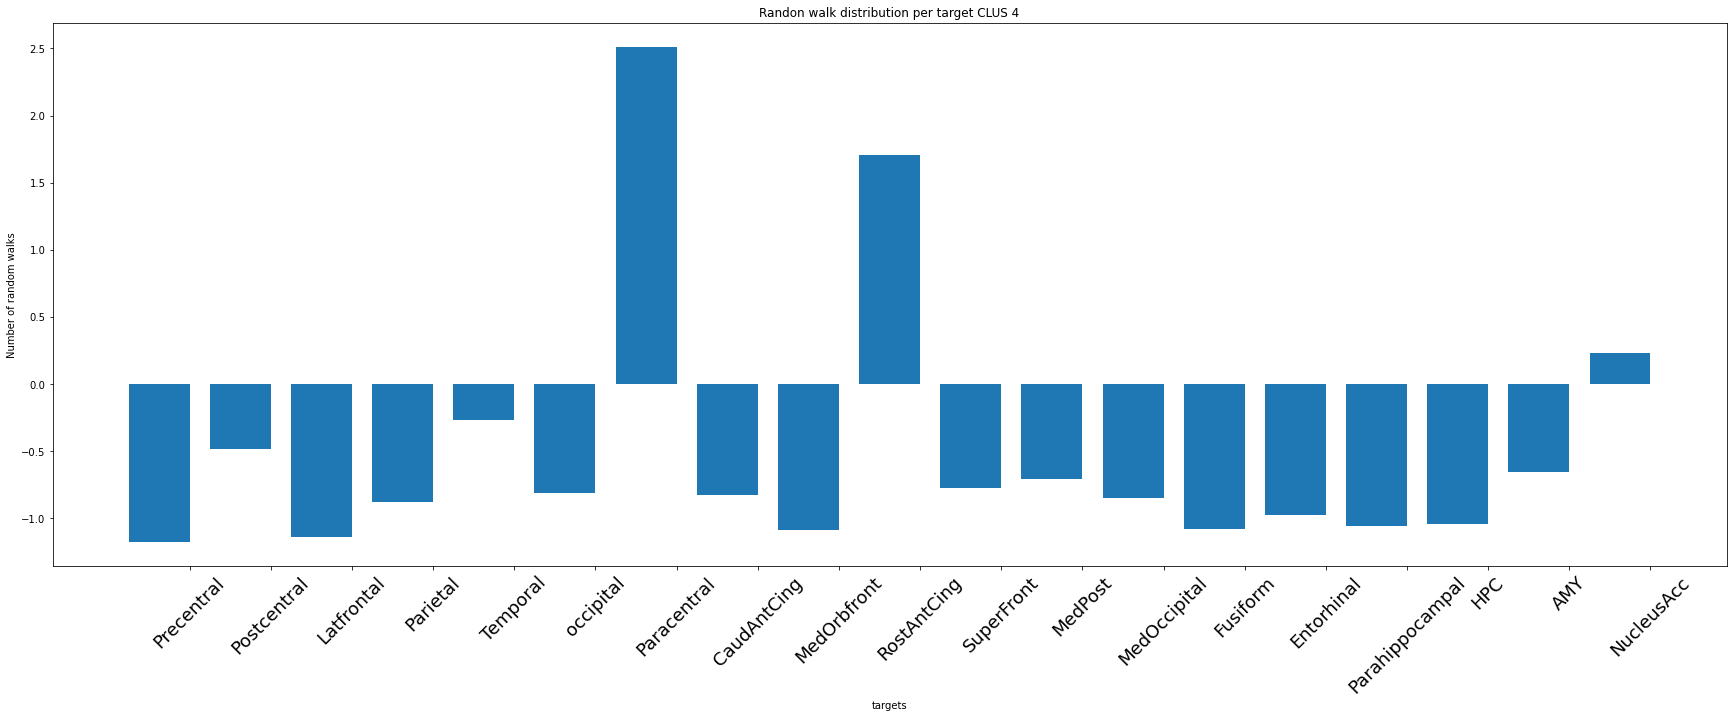

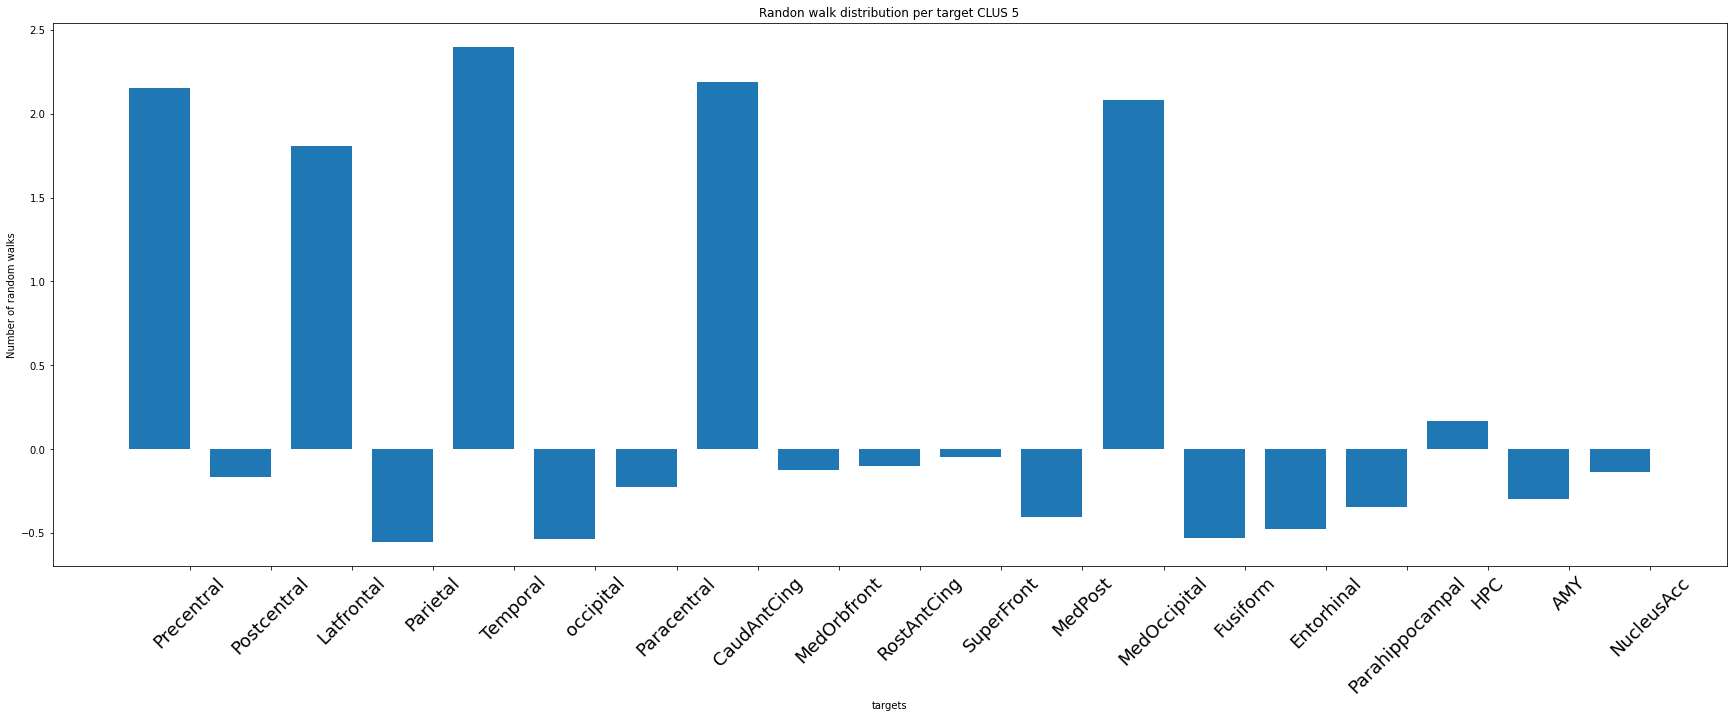

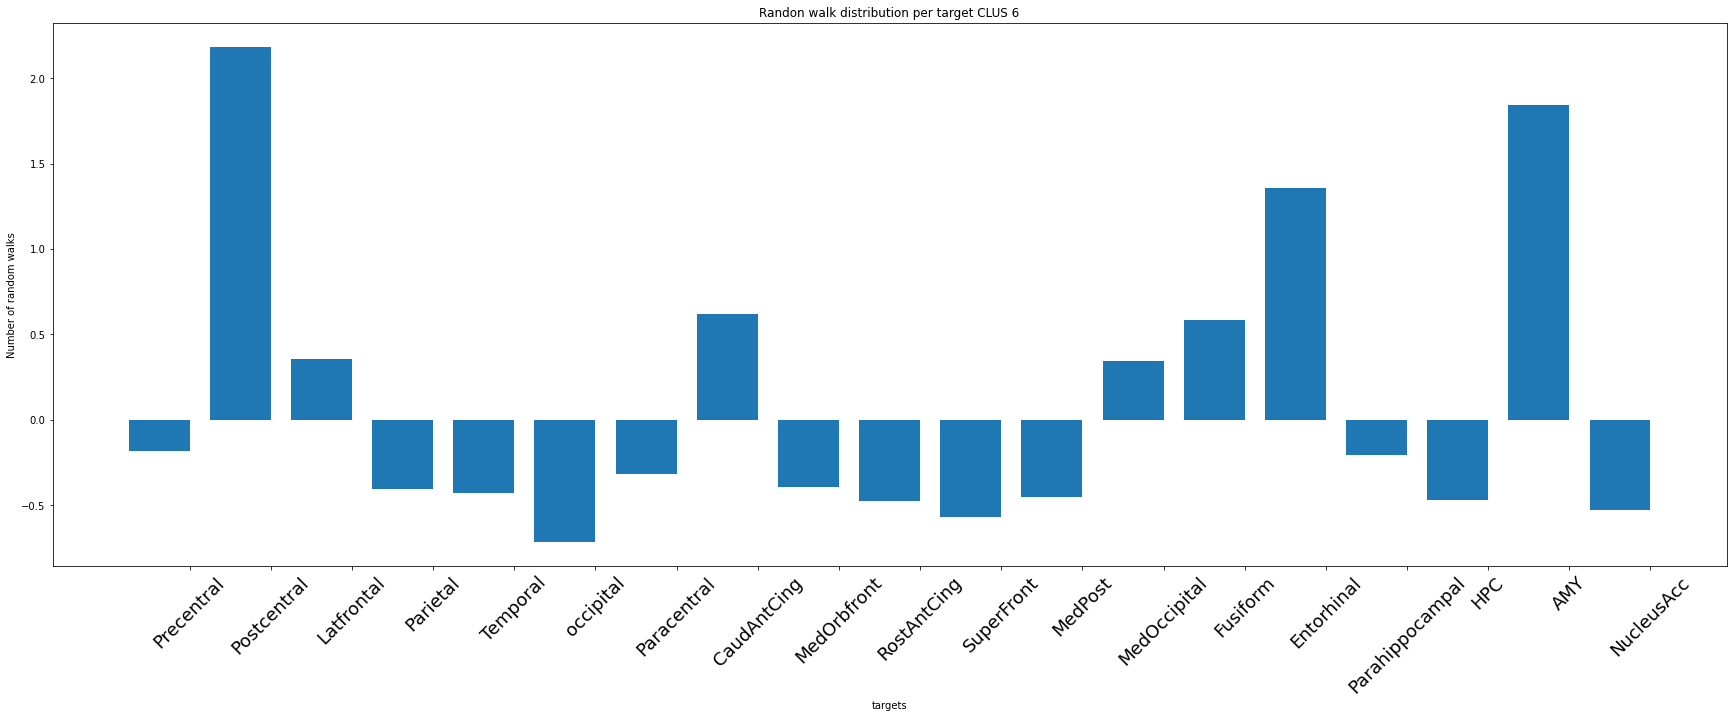

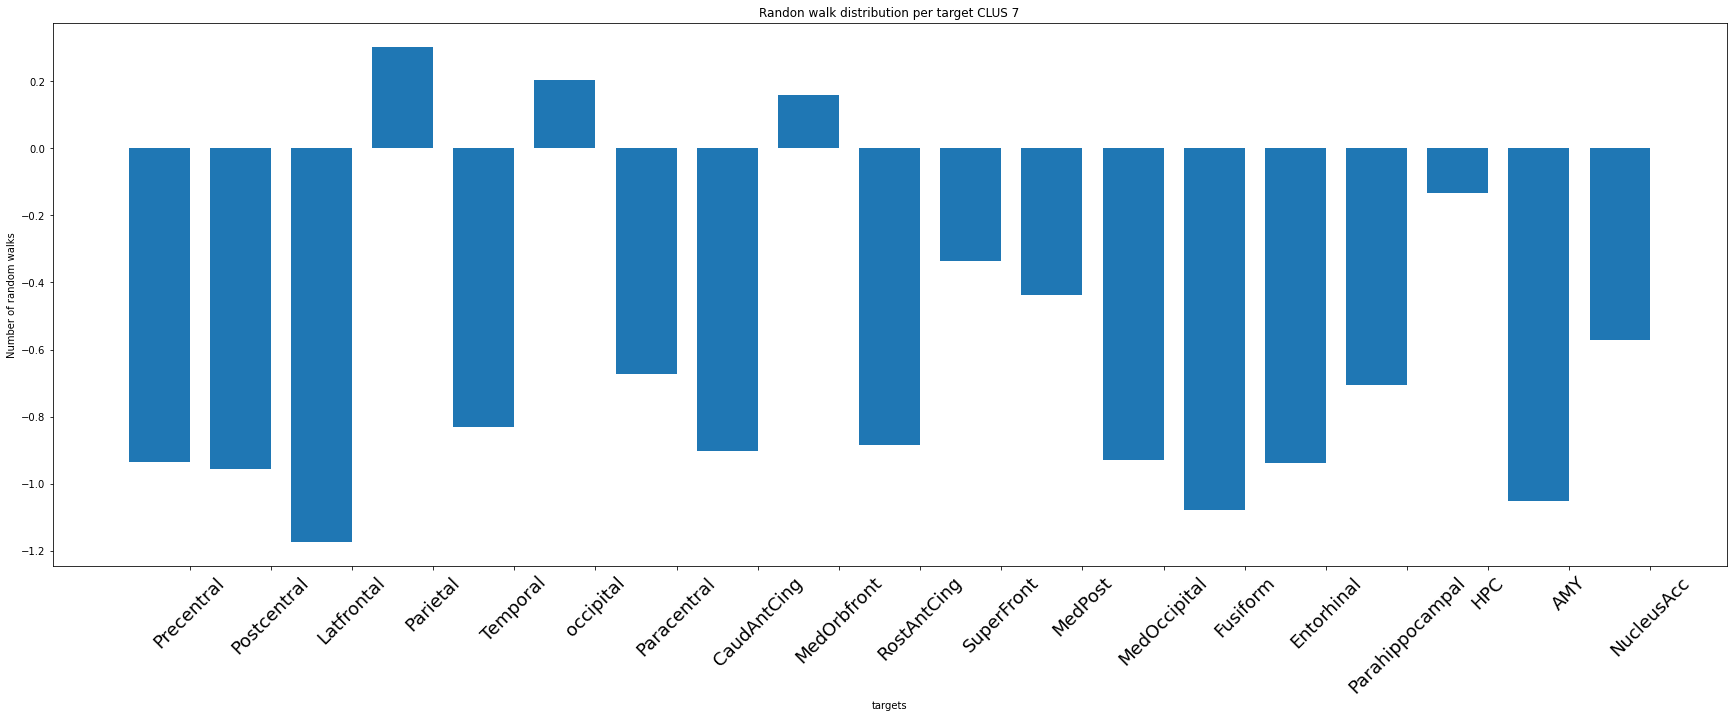

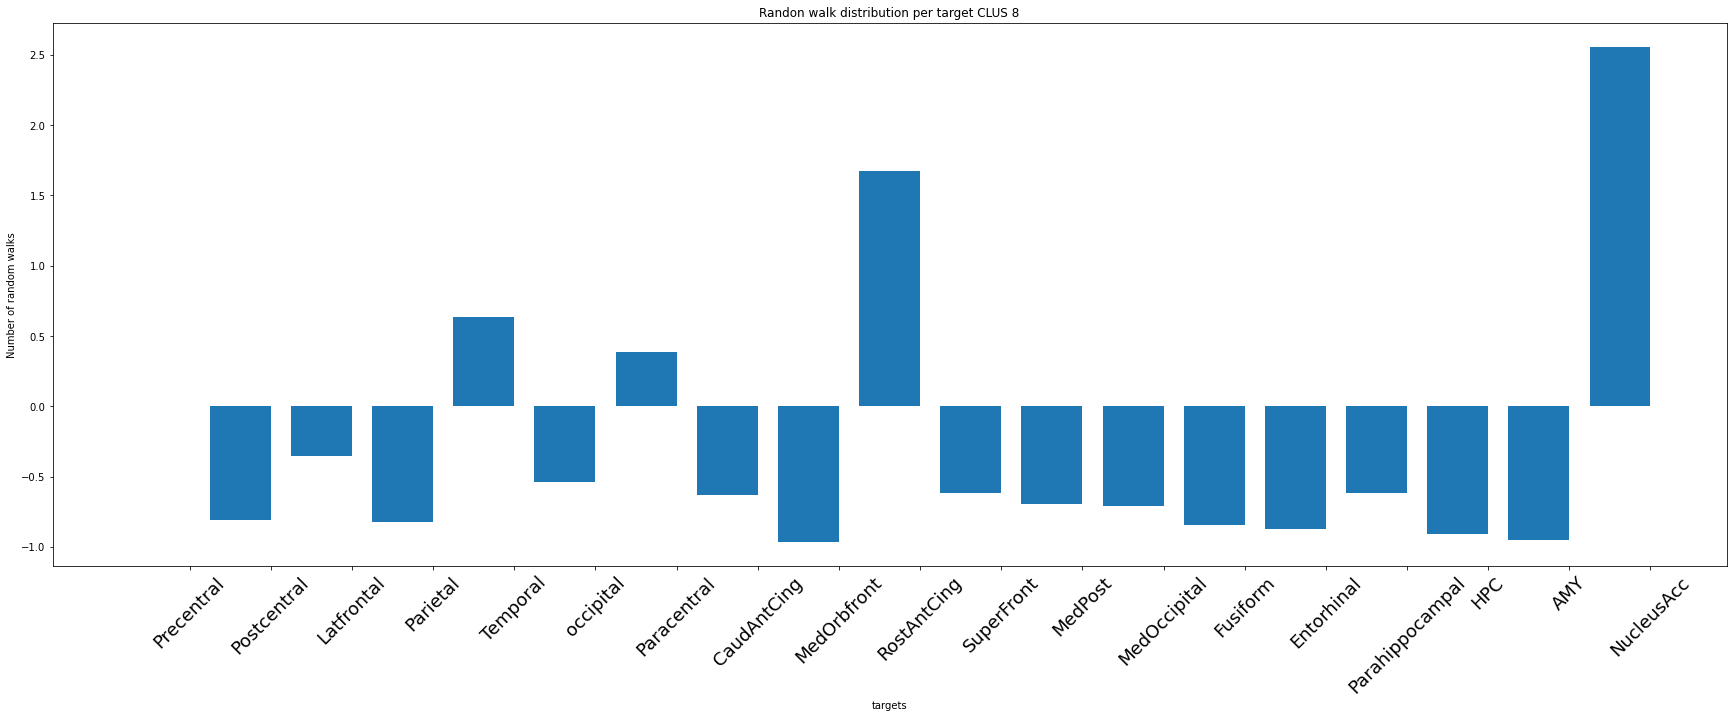

In [3]:
#We check the clusters of the kmeans clustering for 1 subject at a time, for randomly chosen subjects. 
subject_list = ['100307']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    
    root_dir = '/home/data/madlab/data/mri/hcp'
    #loading left and right thalamic masks
    lh_mask = nb.load(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/seed_masks/_seedxfm_fs2dmri0/lft_thal_flirt.nii.gz')[0]) 
    rh_mask = nb.load(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/seed_masks/_seedxfm_fs2dmri1/rt_thal_flirt.nii.gz')[0]) 

    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    lh_mask_data = lh_mask.get_data() #numpy array 1s and 0s
    lh_mask_data[:,0:80,:] = 0 #according to orginal script. This changes for every dataset
    #taking last slice and making 0 as this is the slice next to the hippocampus.
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:80,:] = 0
    
    #Creating a loop to analyze left and right hemisphere separately
    for hemi in ['0','1']: #0 = left, 1 = right
        if hemi == '0':
            out_file = ('/home/data/madlab/data/mri/hcp/kmeans/kmeans_feature_clusters/{0}_kmeans_thallh_{1}-clus.nii.gz'.format(subject_id, n_clus))
            curr_hemi_mask = lh_mask_data
            curr_hemi_targ_files = glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/targets/_pbx20/*nii.gz') 
        else:
            out_file = ('/home/data/madlab/data/mri/hcp/kmeans/kmeans_feature_clusters/{0}_kmeans_thalrh_{1}-clus.nii.gz'.format(subject_id, n_clus))
            curr_hemi_mask = rh_mask_data
            curr_hemi_targ_files = glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/targets/_pbx21/*nii.gz')
        
        curr_hemi_mask_data_dims = curr_hemi_mask.shape
        
    
        #creates an feature by voxel array
        #Aka how often a random walk ended up from each voxel of tha thalamus to the target
        for i, curr_targ_files in enumerate(curr_hemi_targ_files):
            curr_targ = nb.load(curr_targ_files).get_data() #read about .get_data on nibabel #this is now a matrix of numbers
            #Grabbing only the data within the thalamus (which is labeled as 1)
            curr_targ_thalonly_data = curr_targ[curr_hemi_mask > 0] 
            #reshaping our thalamus data into a 1-D numpy array
            curr_targ_thalonly_data_col = curr_targ_thalonly_data.reshape(np.int(np.sum(curr_hemi_mask)),1)
            #Now we make a voxel by target matrix where y = voxels in thalamus, and x cols is the targets
            #This will go into the kmeans algorithm
            if i == 0:
                alltarg_thalonly_img_data = curr_targ_thalonly_data_col
            else:
                alltarg_thalonly_img_data = np.concatenate((alltarg_thalonly_img_data, curr_targ_thalonly_data_col),1)

        #input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) for lh, rh in bilat_targ_files], axis = 1)
        #Now we take the 3 dimensions so we can put the data back into brain space
        rl_thal = curr_hemi_mask_data_dims[0]
        ap_thal = curr_hemi_mask_data_dims[1]
        is_thal = curr_hemi_mask_data_dims[2]
        
        #This runs the kmeans algorithm (currently with 8 clusters)
        thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
        #Setting our out file
        thal_kmeans_out = thal_kmeans.fit_predict(alltarg_thalonly_img_data) + 1
        #thal_kmeans_out a vector out of the thal mask between 1-8 clusters with as many numbers as voxels in thalamus
        thal_kmeans_results = curr_hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal) #making it into a vector
    
        #replacing kmeans values wherever there is a one (in thal mask) with the cluster number from the kmeans output
        i = 0
        for idx, value in enumerate(thal_kmeans_results):
            if value > 0:
                thal_kmeans_results[idx] = thal_kmeans_out[i] #i is number between 1 and 8 putting it into idx
                i += 1
        
        #reshape the column back to original n x y x n shape from vector
        thal_kmeans_results = thal_kmeans_results.reshape(curr_hemi_mask_data_dims)
        #Saving the new voxels as a .nii.gz file
        thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, hemi_affine, hemi_header) 
        #returning a string which represents the current working directory.
        kmeans_file_dir = (out_file)
        if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
            os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
        thal_kmeans_imag.to_filename(kmeans_file_dir)
        
        #calculating z-scores (including mean) for each cluster
        for x in range(len(thal_kmeans.cluster_centers_[:,0])):
        #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
            curr_thal_feature_z = []
            #running the for loop for each cluster 
            for y in range(len(thal_kmeans.cluster_centers_[0,:])):
                curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                            np.mean(thal_kmeans.cluster_centers_[:,y])) \
                            /np.std(thal_kmeans.cluster_centers_[:,y])
                curr_thal_feature_z.append(curr_thal_z)
            if x == 0:
                all_thal_features_z = curr_thal_feature_z
            else:
                all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
        
        #CLUSTER 1
        y1 = all_thal_features_z[0]

        x1 = np.arange(len(y1))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 1')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x1, y1, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x1)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()
        
        #CLUSTER 2
        y2 = all_thal_features_z[1]

        x2 = np.arange(len(y2))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 2')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x2, y2, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x2)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 3
        y3 = all_thal_features_z[2]

        x3 = np.arange(len(y3))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 3')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x3, y3, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x3)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 4
        y4 = all_thal_features_z[3]

        x4 = np.arange(len(y4))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 4')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x4, y4, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x4)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 5
        y5 = all_thal_features_z[4]

        x5 = np.arange(len(y5))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 5')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x5, y5, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x5)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 6
        y6 = all_thal_features_z[5]

        x6 = np.arange(len(y6))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 6')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x6, y6, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x6)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 7
        y7 = all_thal_features_z[6]

        x7 = np.arange(len(y7))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 7')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x7, y7, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x7)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 8
        y8 = all_thal_features_z[7]

        x8 = np.arange(len(y8))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,10))
        plt.title('Randon walk distribution per target CLUS 8')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x8, y8, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x8)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()


******************************************************************************************************
******************************************************************************************************
******************************************************************************************************

# Participant 100408

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: get_data() is deprecated in favor of get_fdata(),

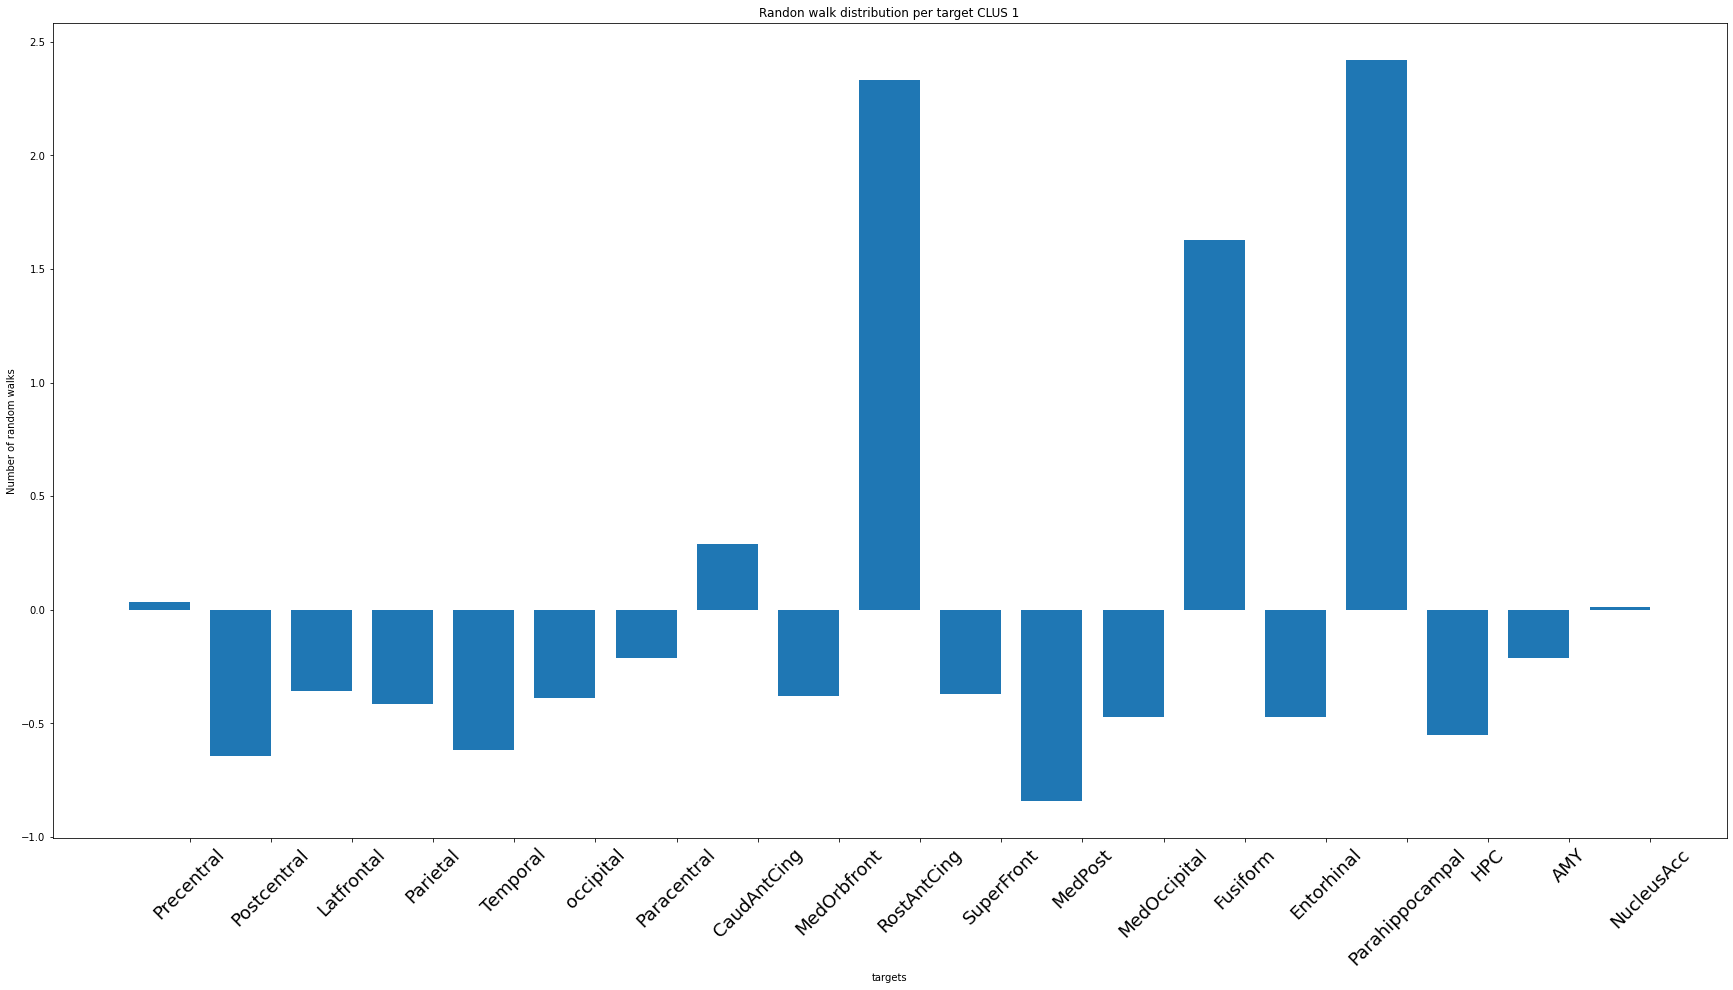

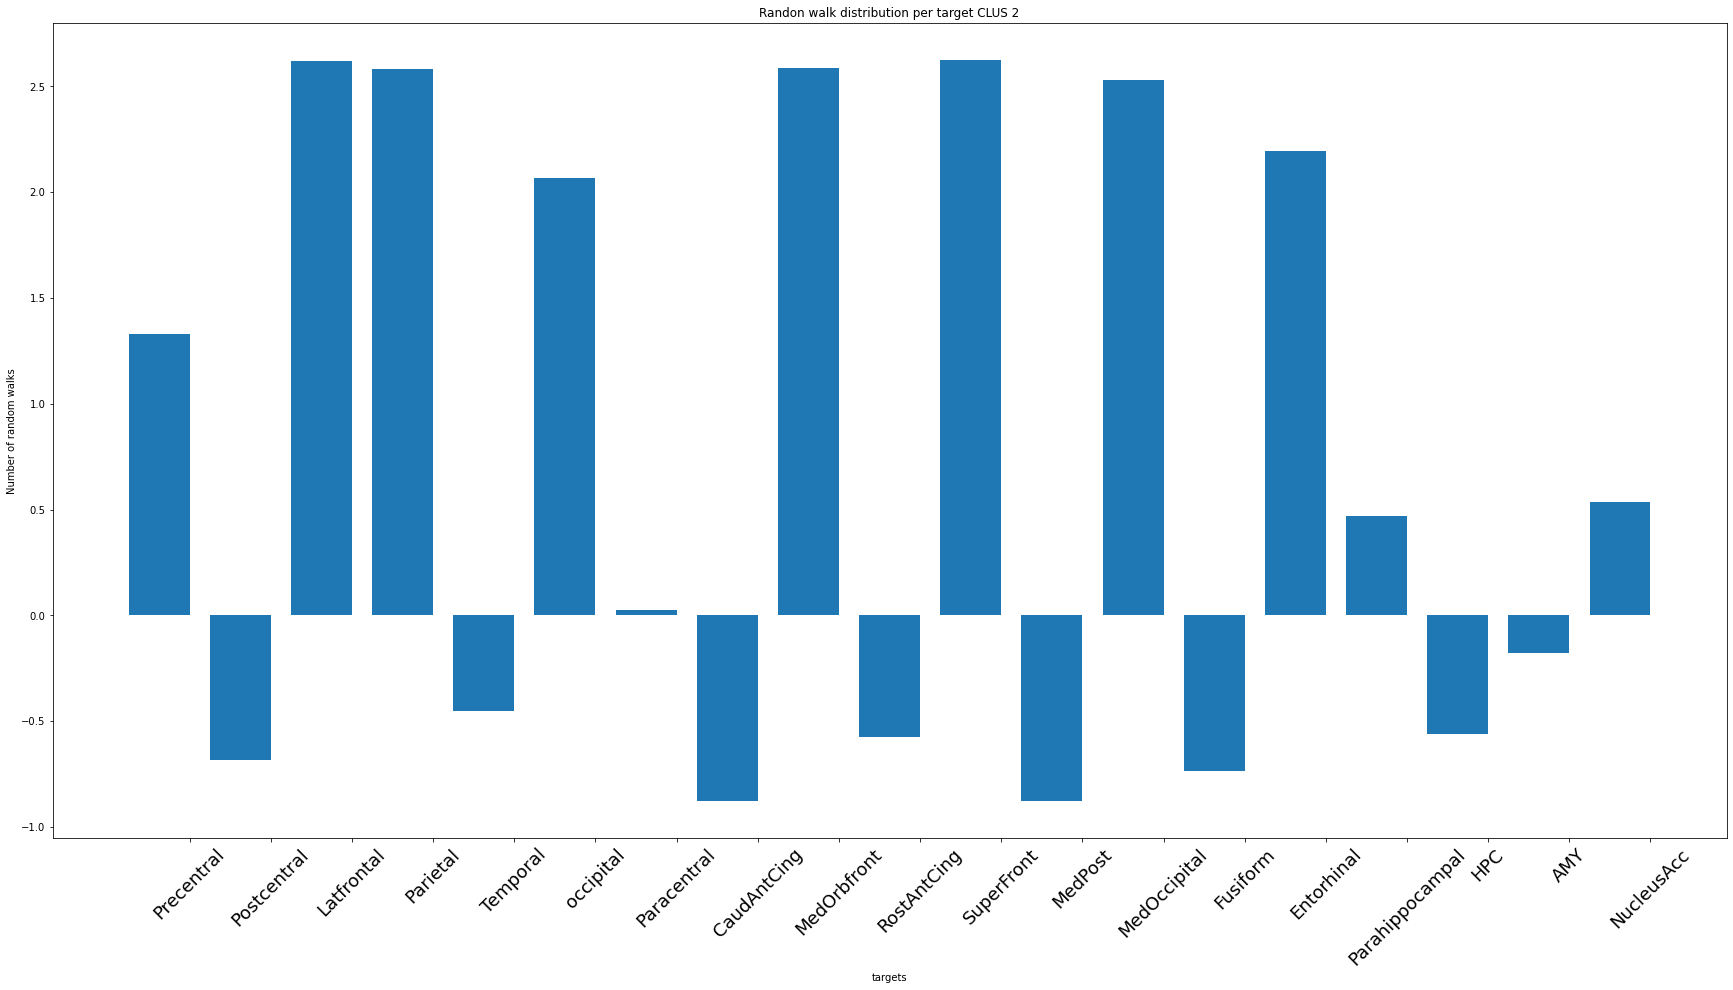

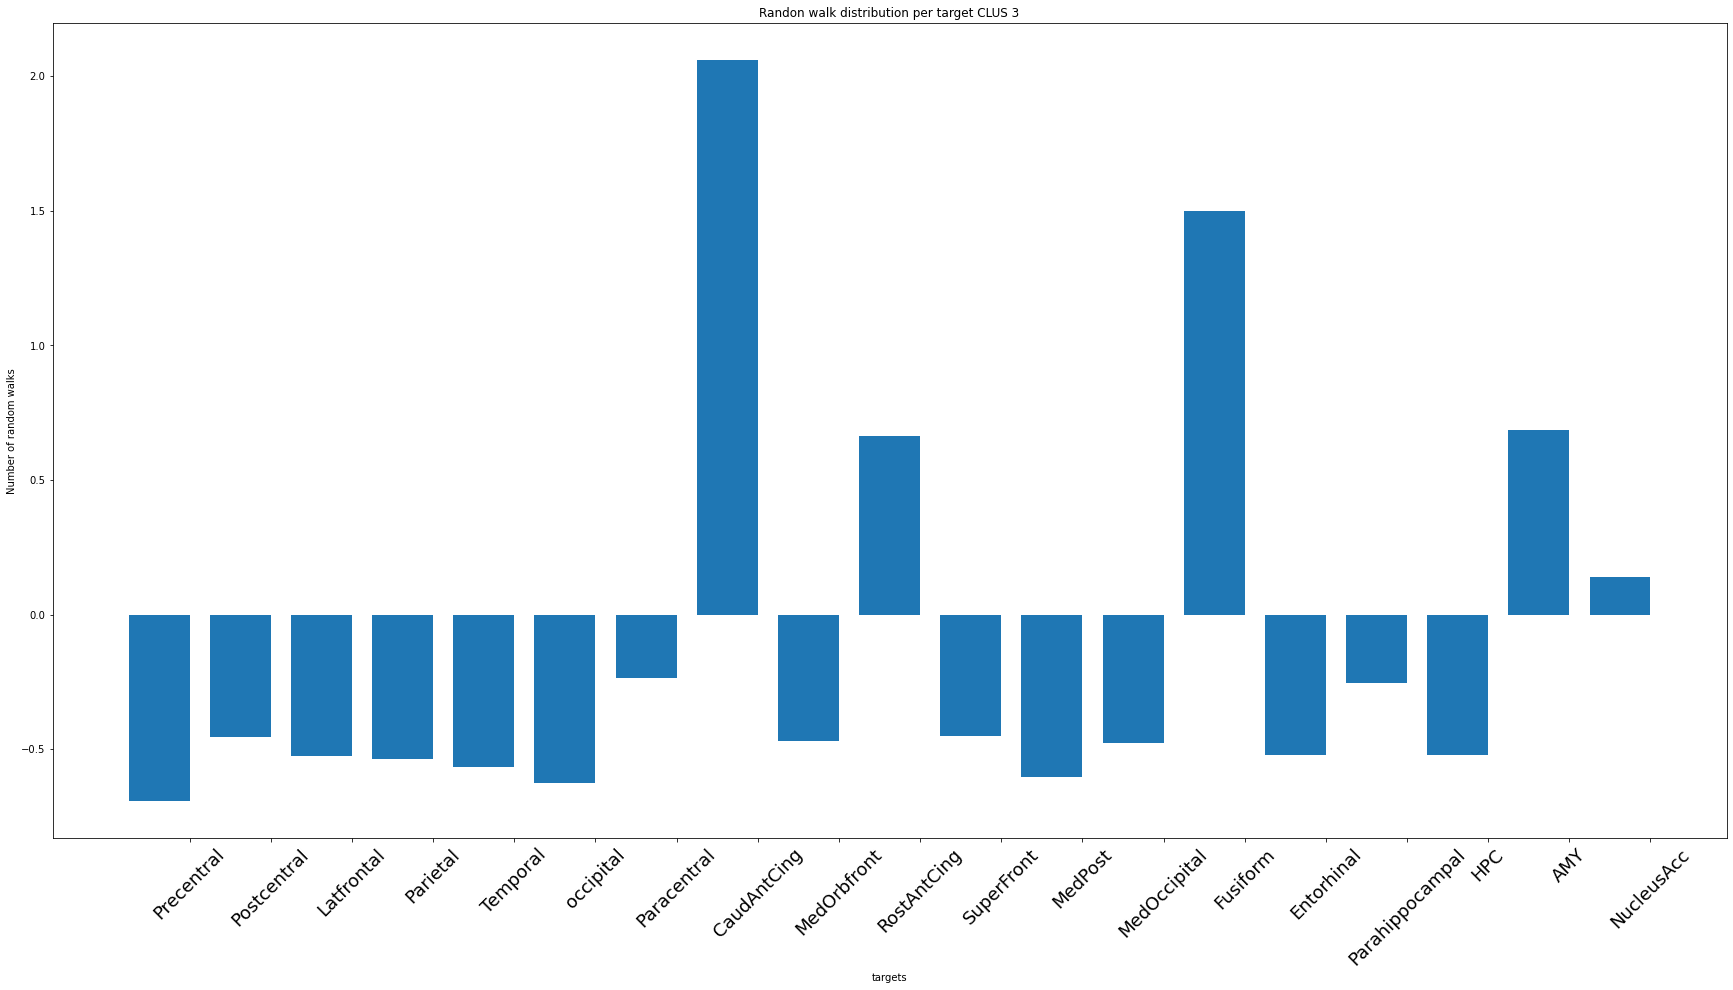

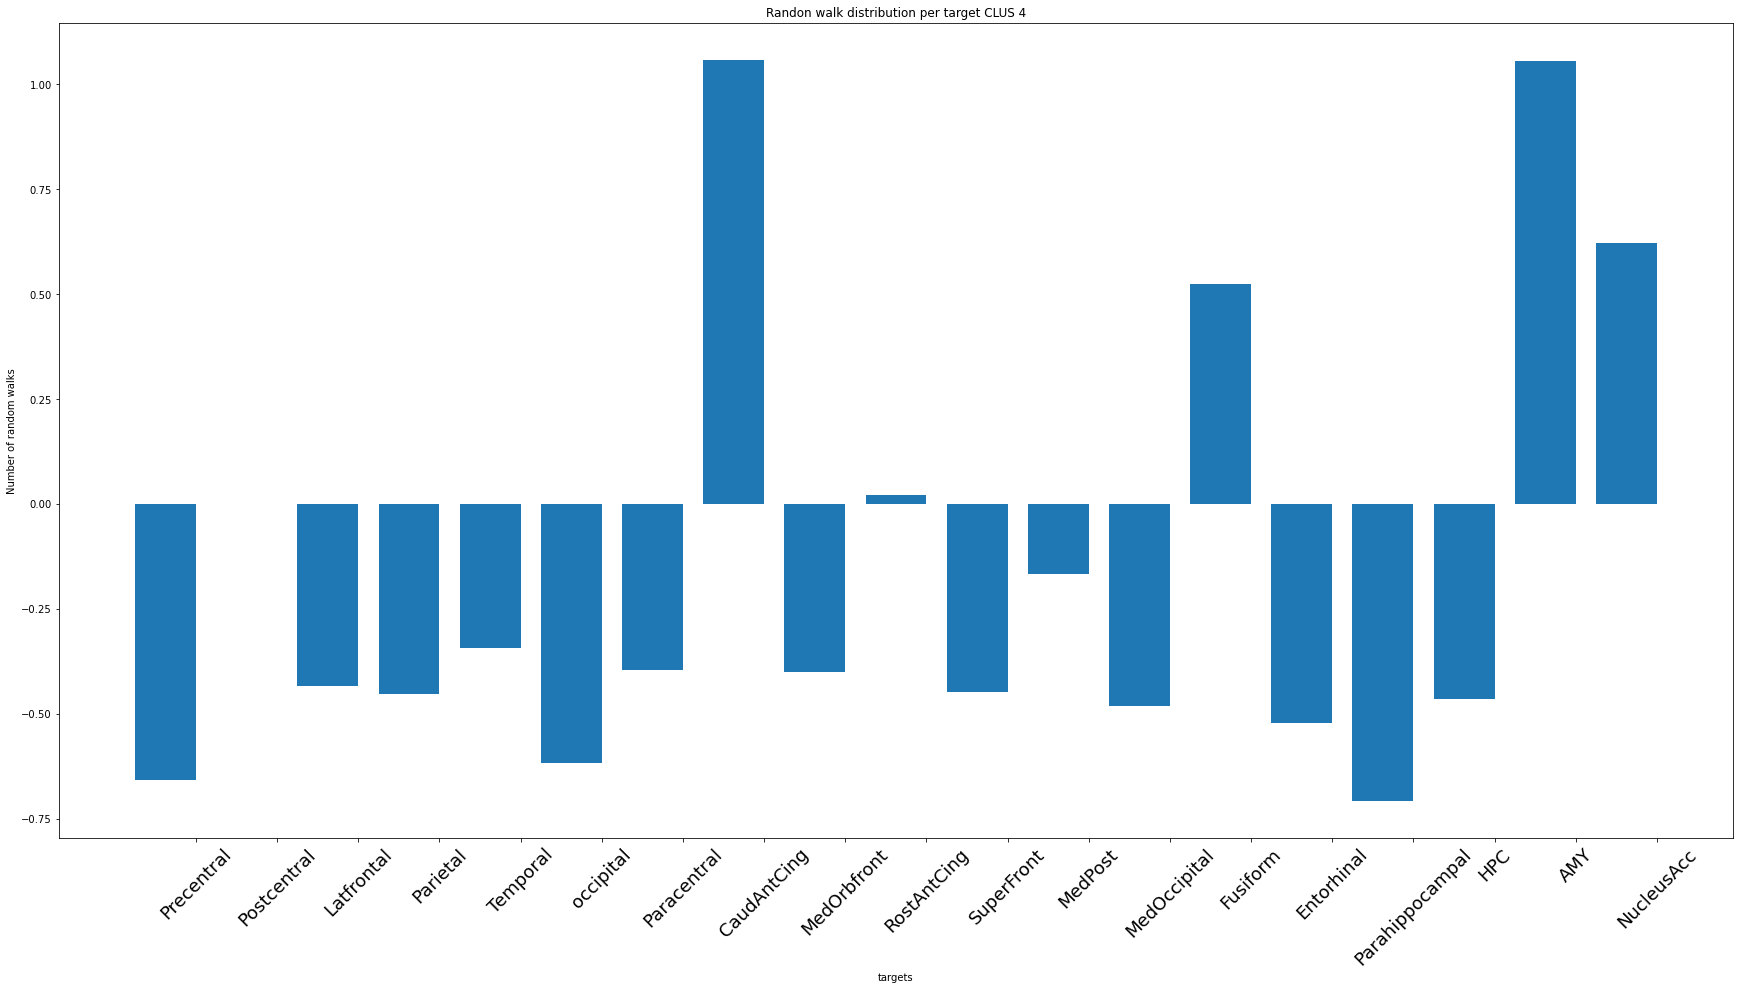

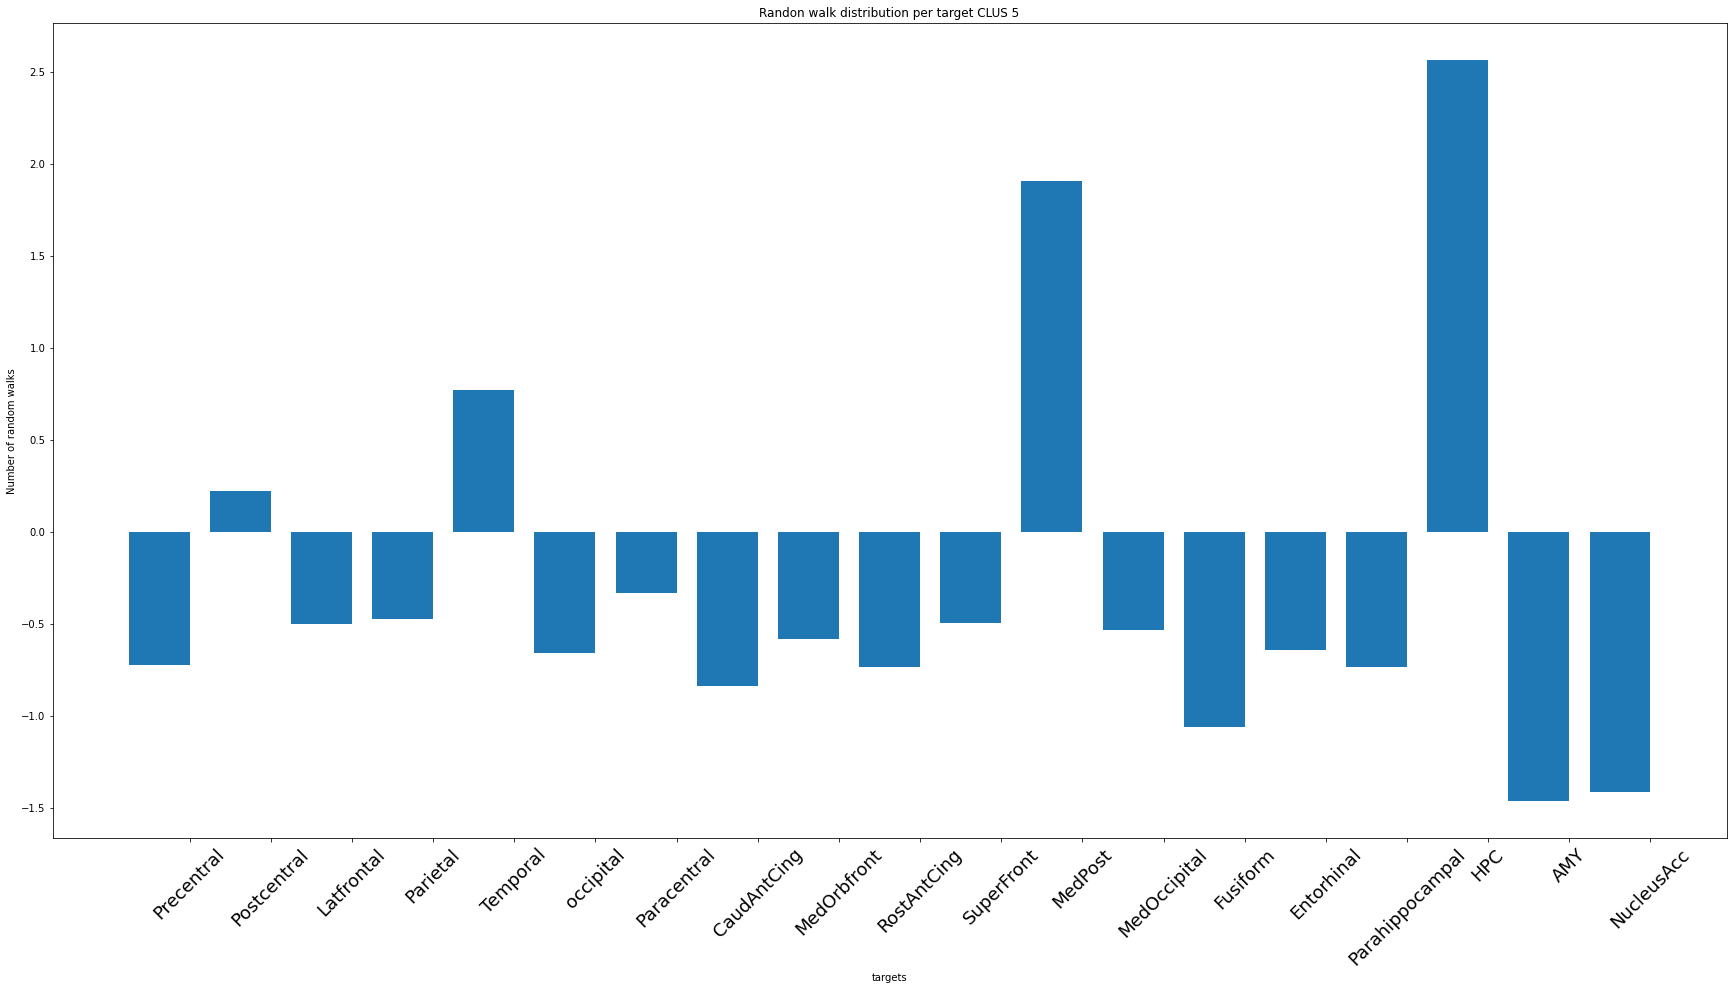

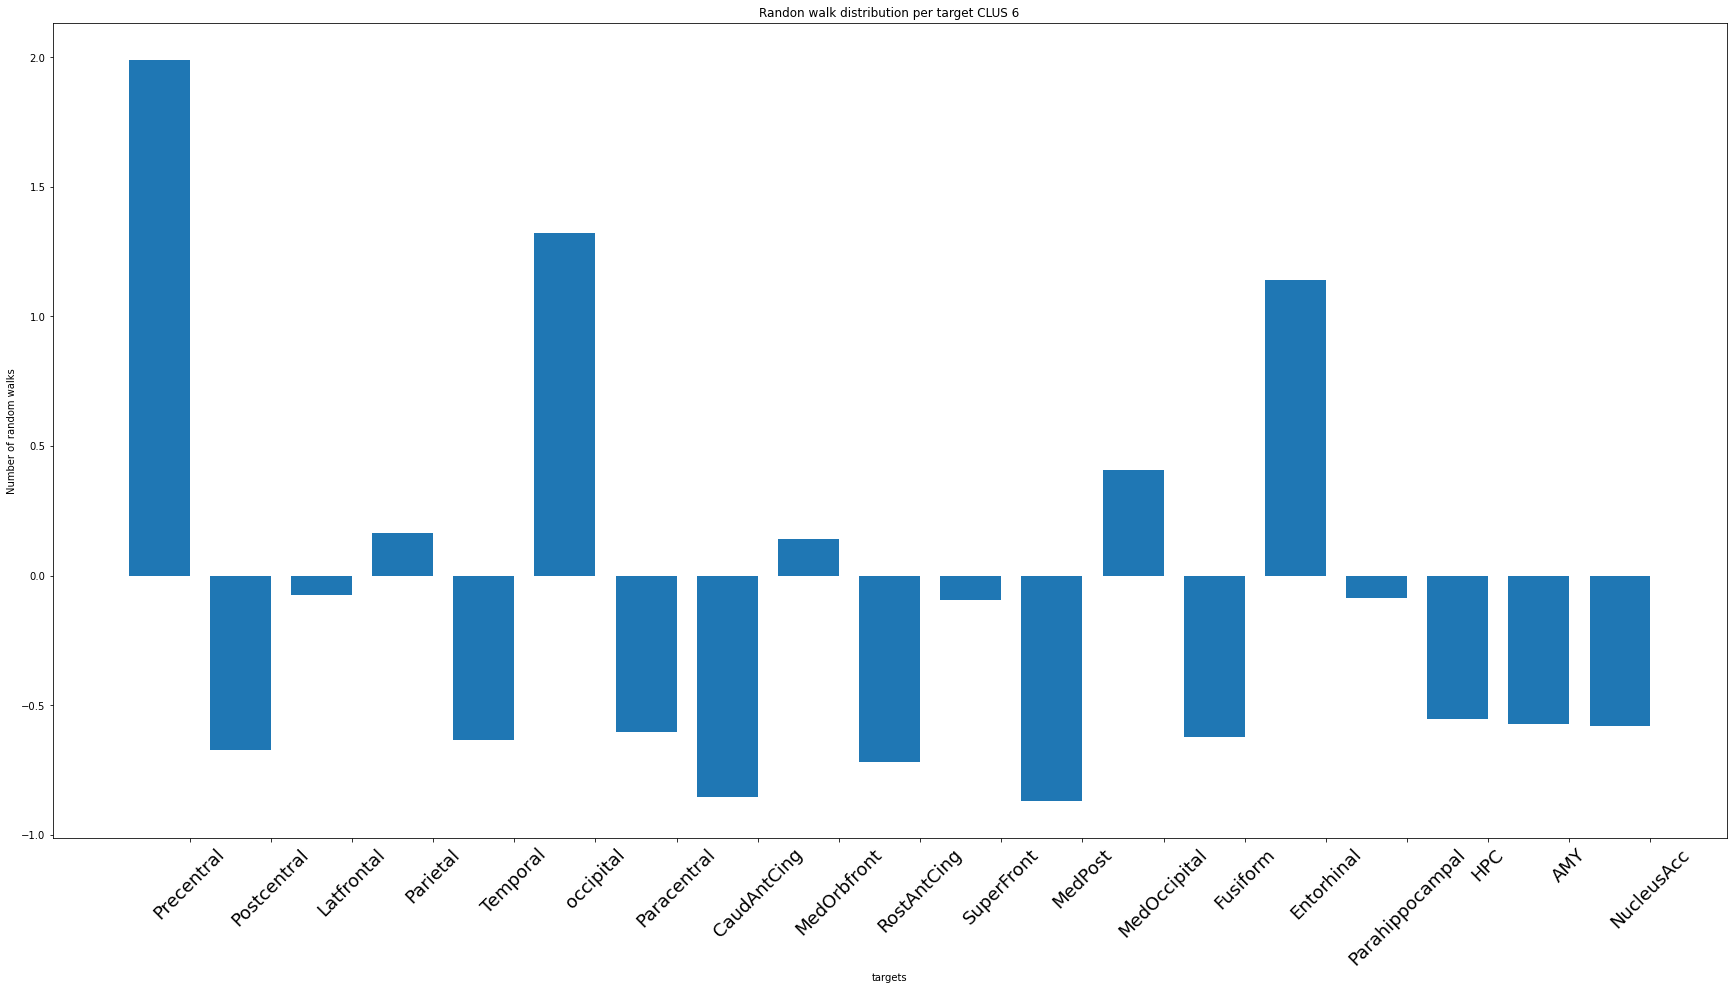

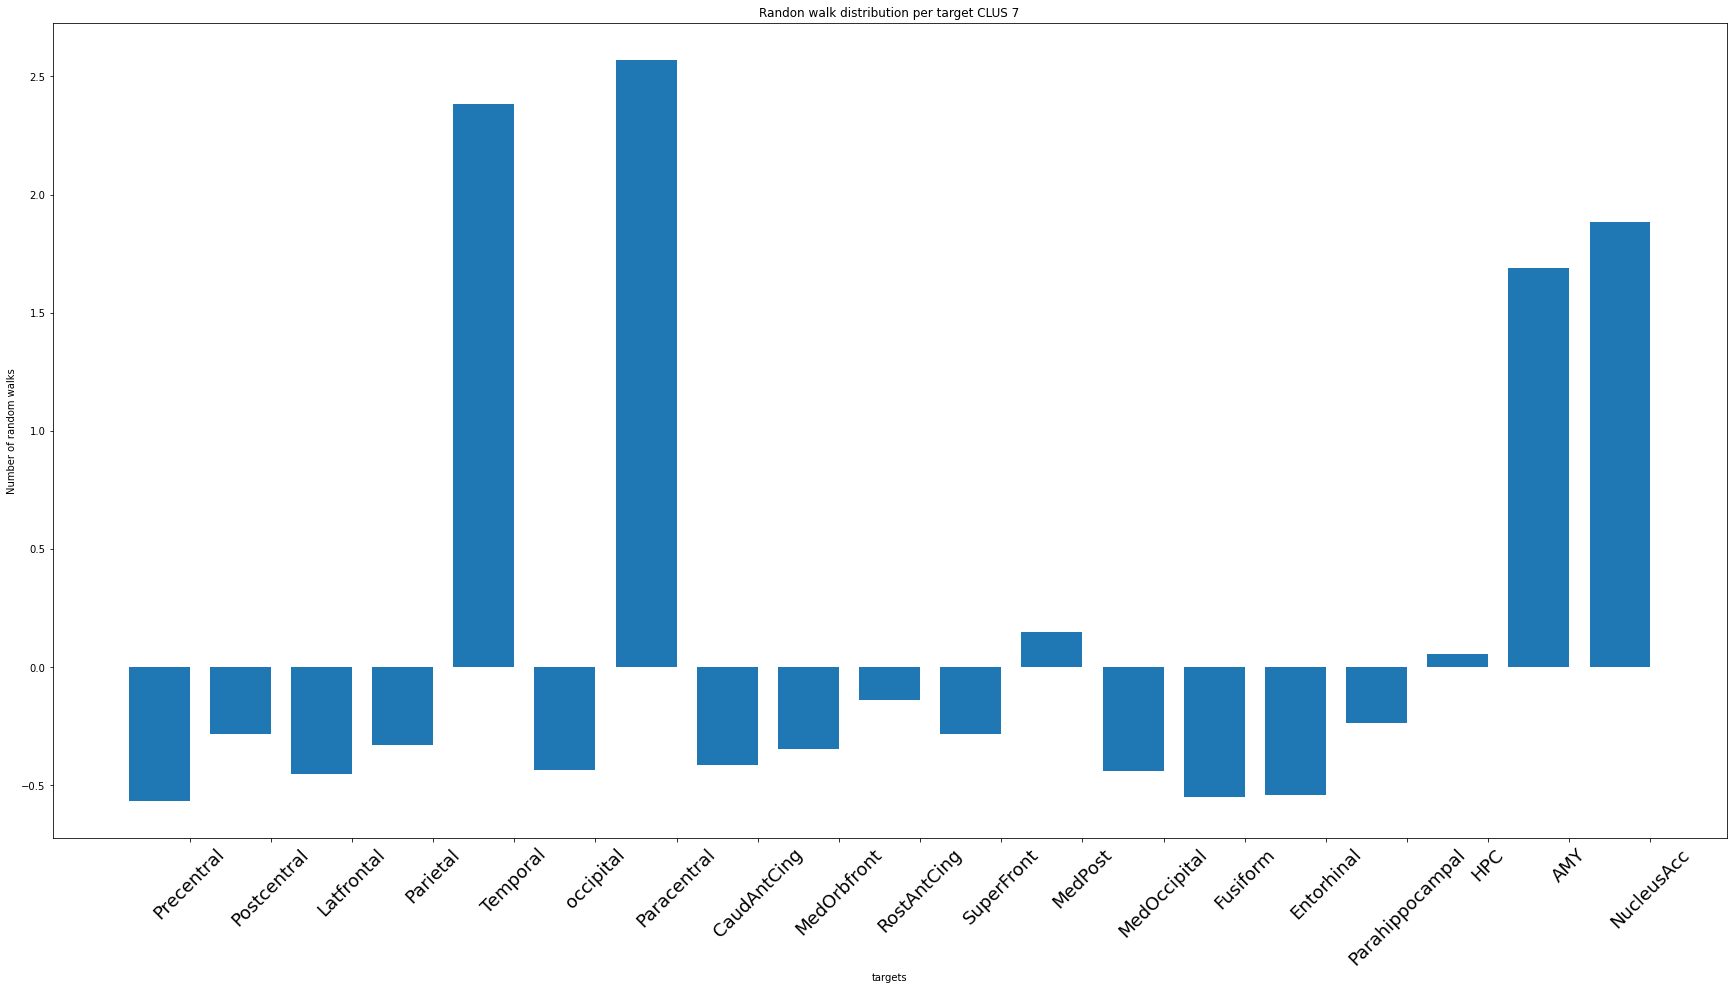

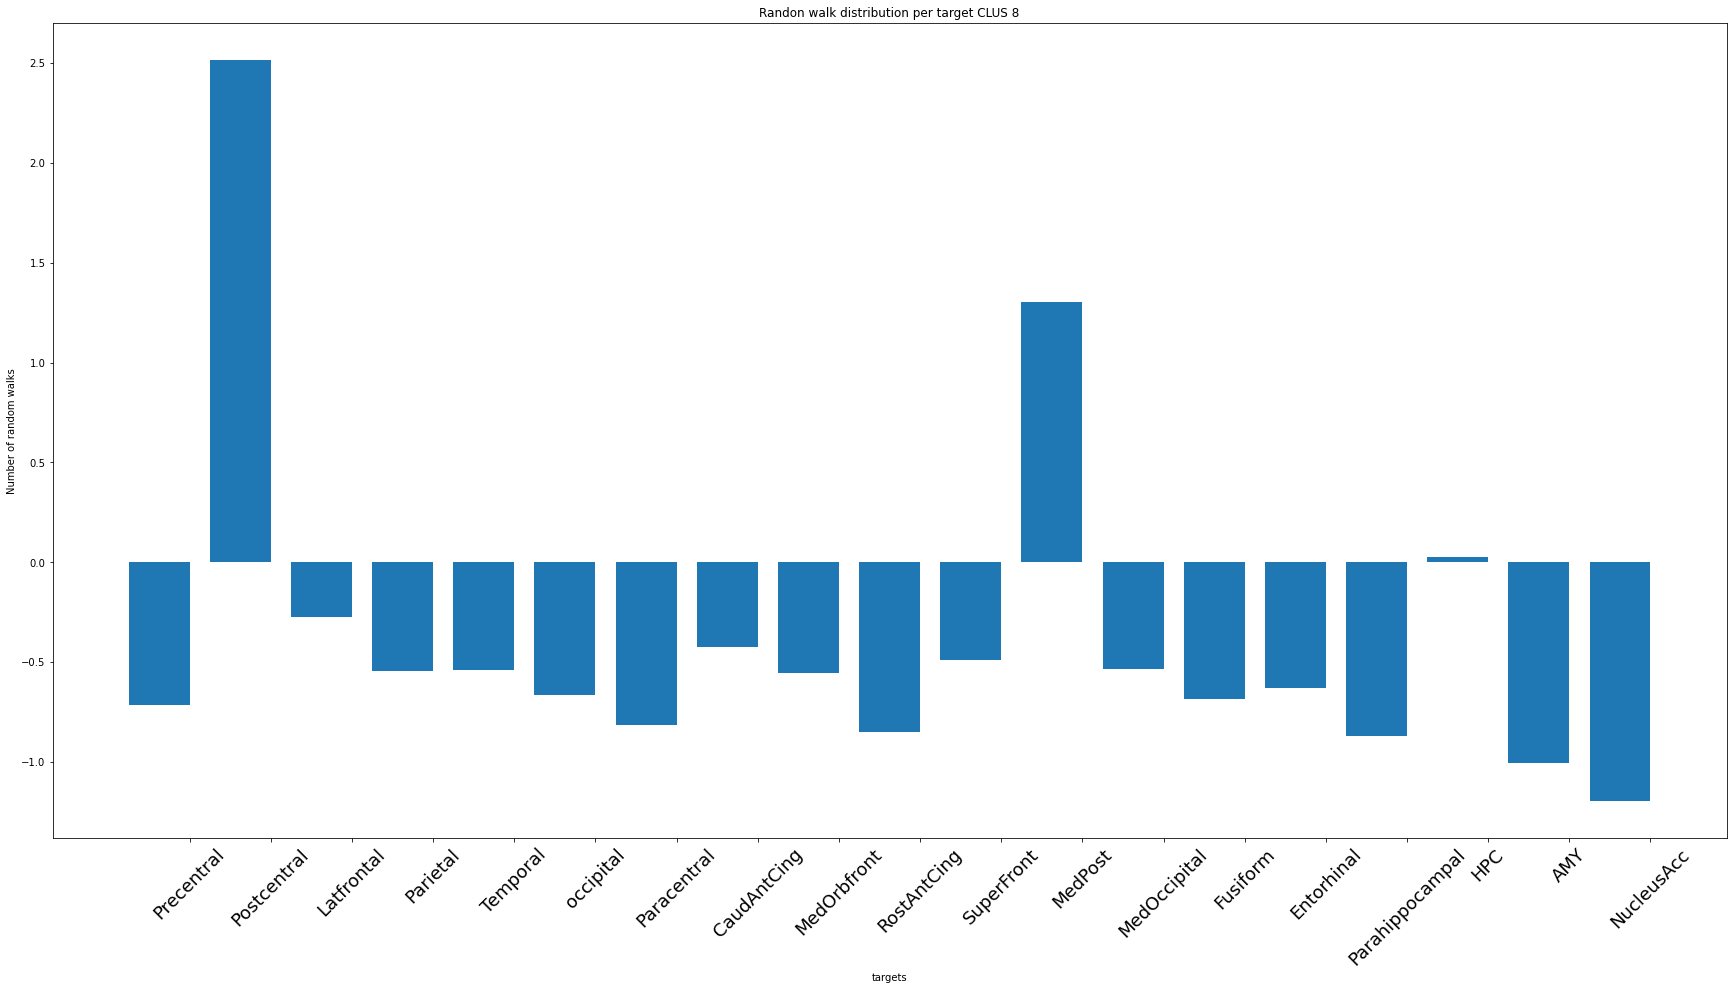

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


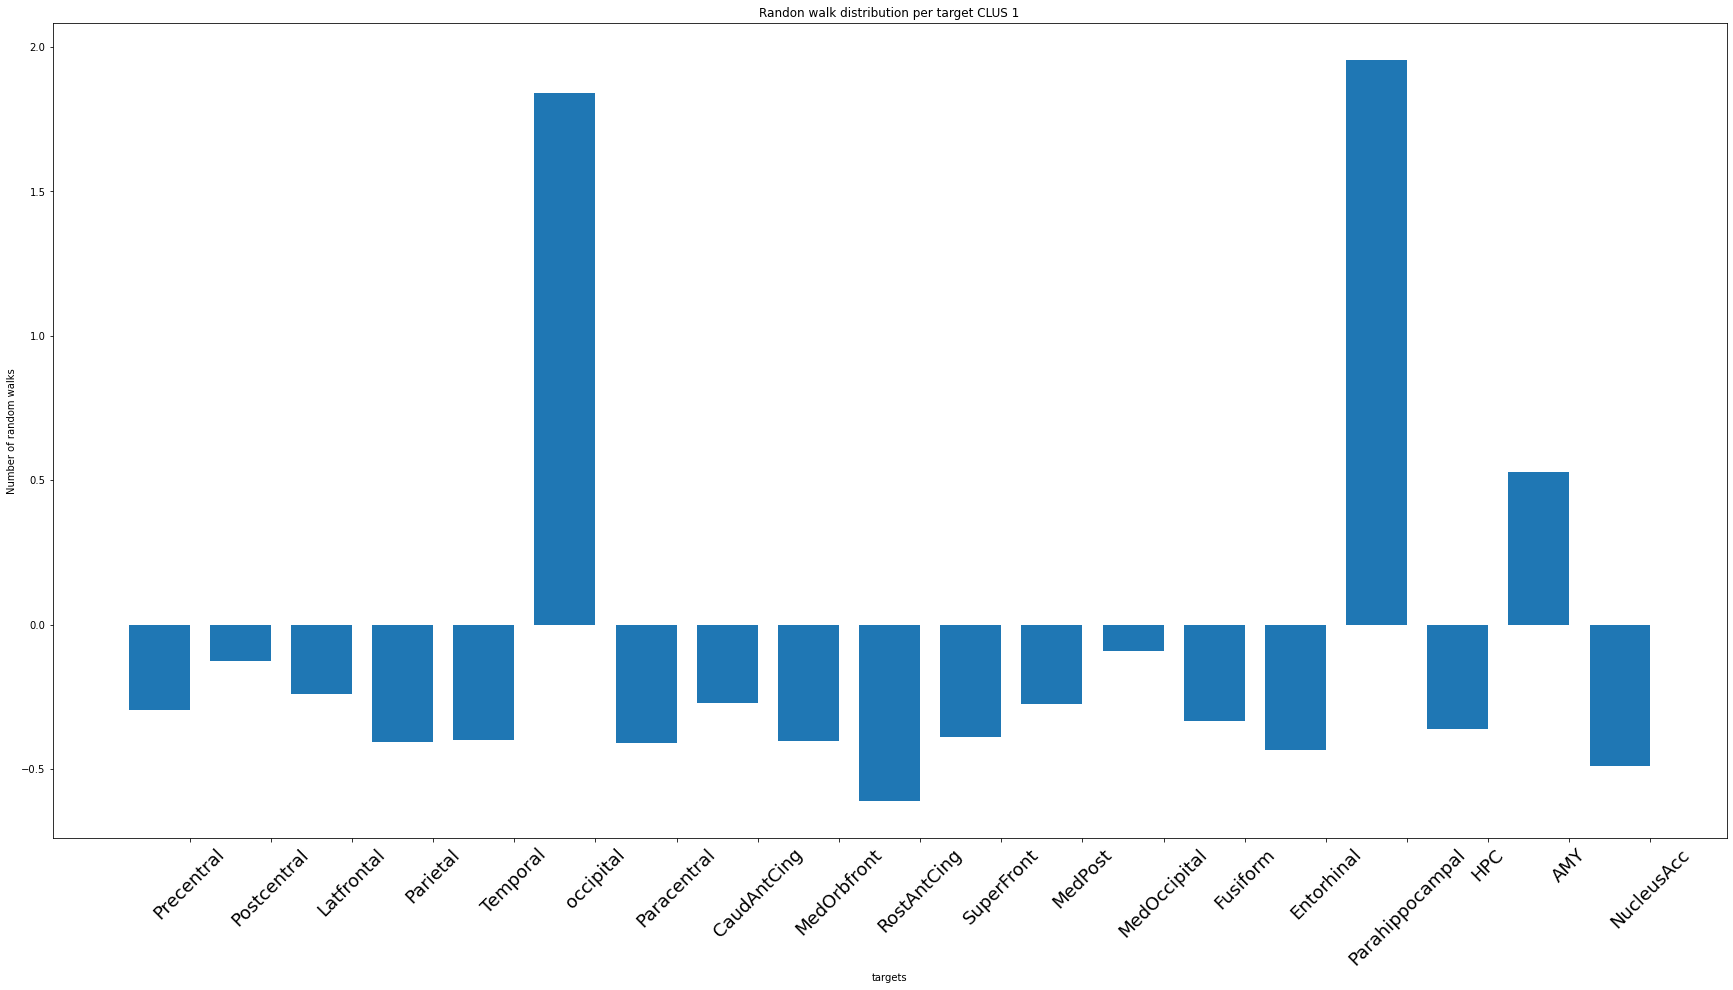

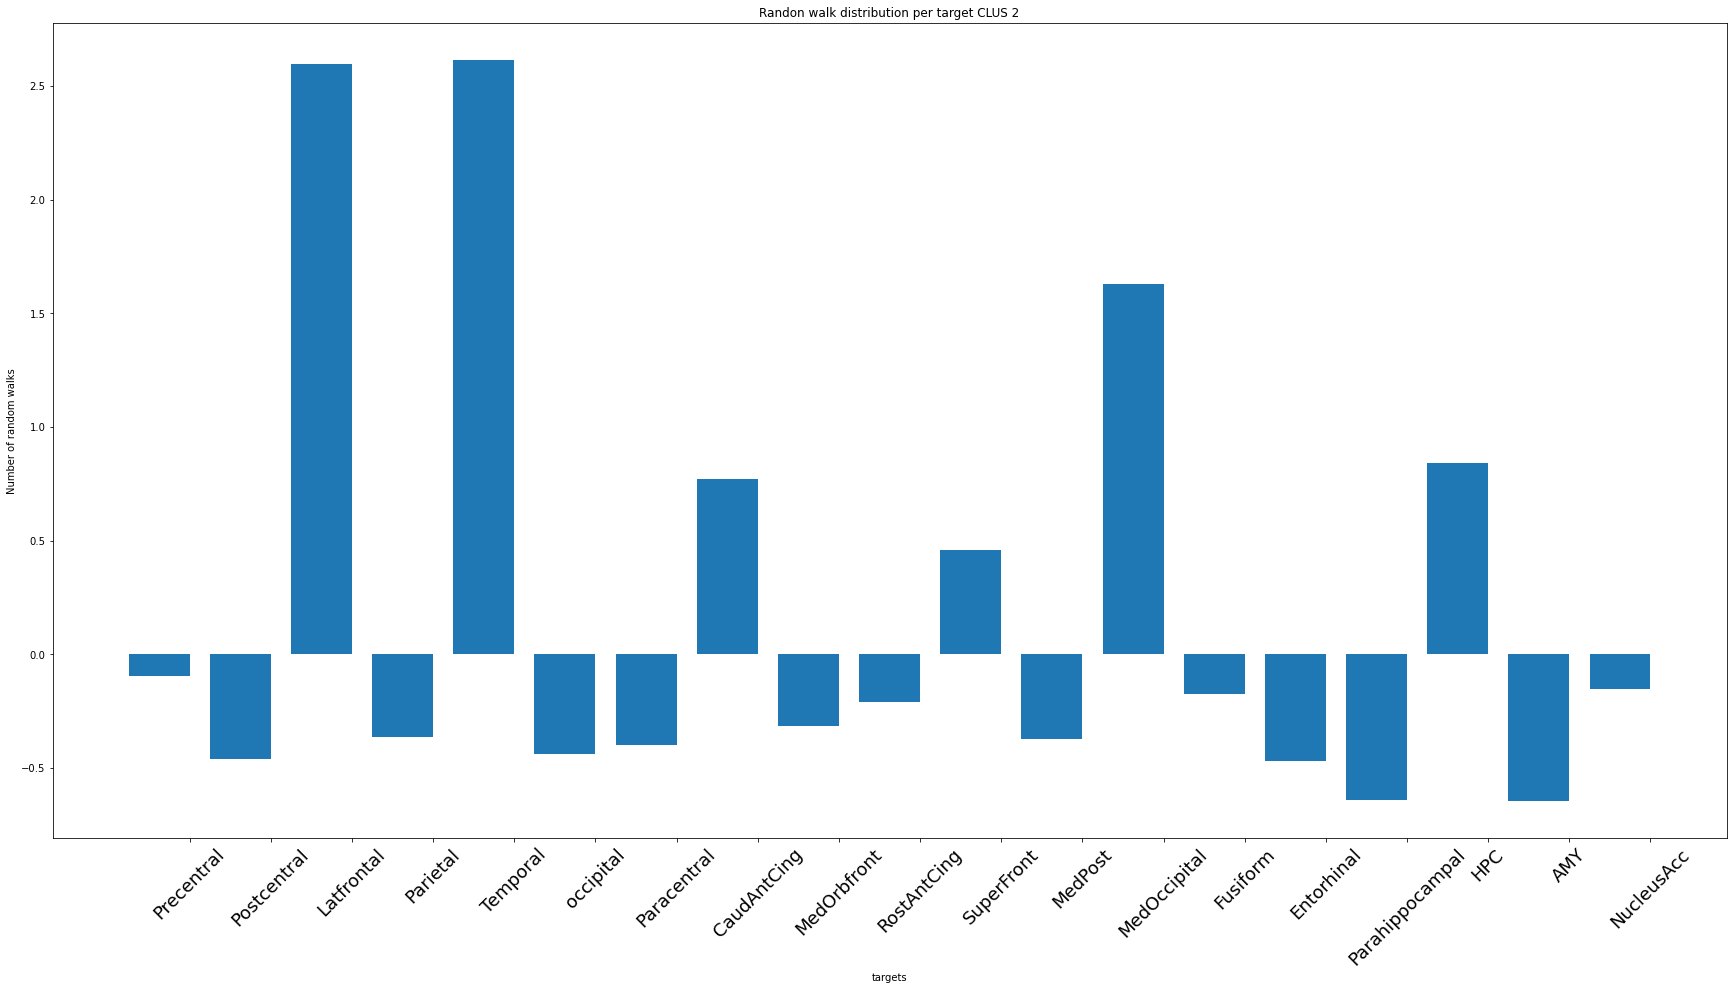

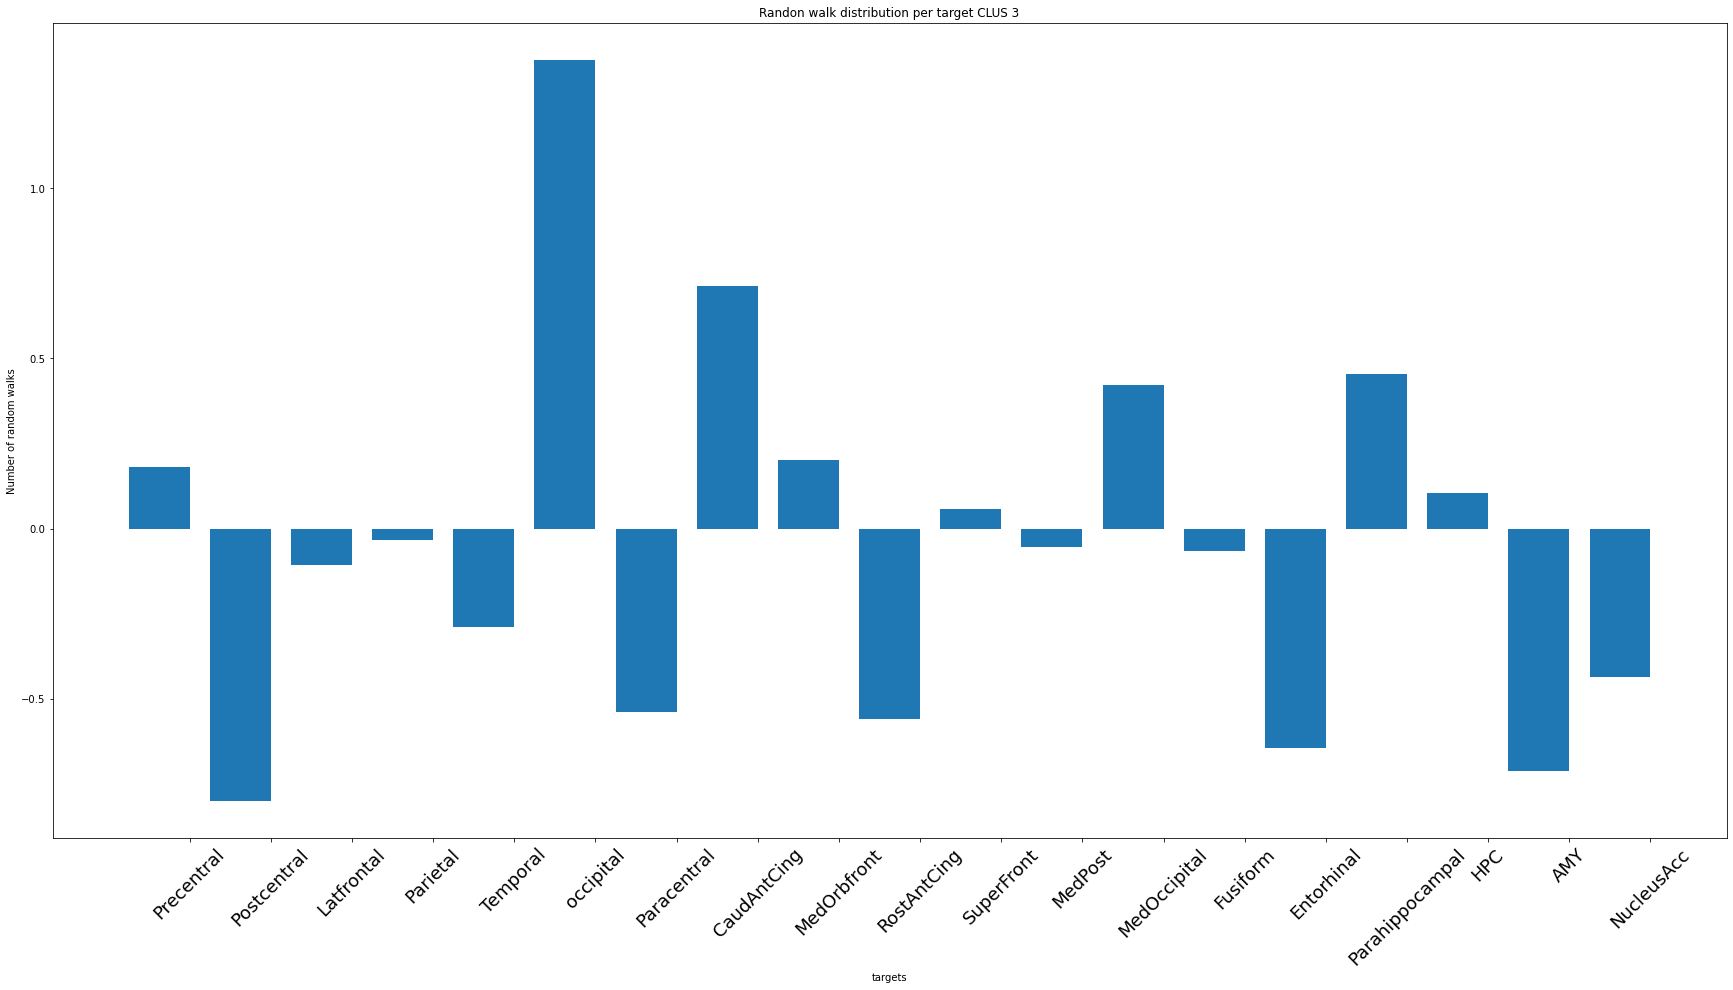

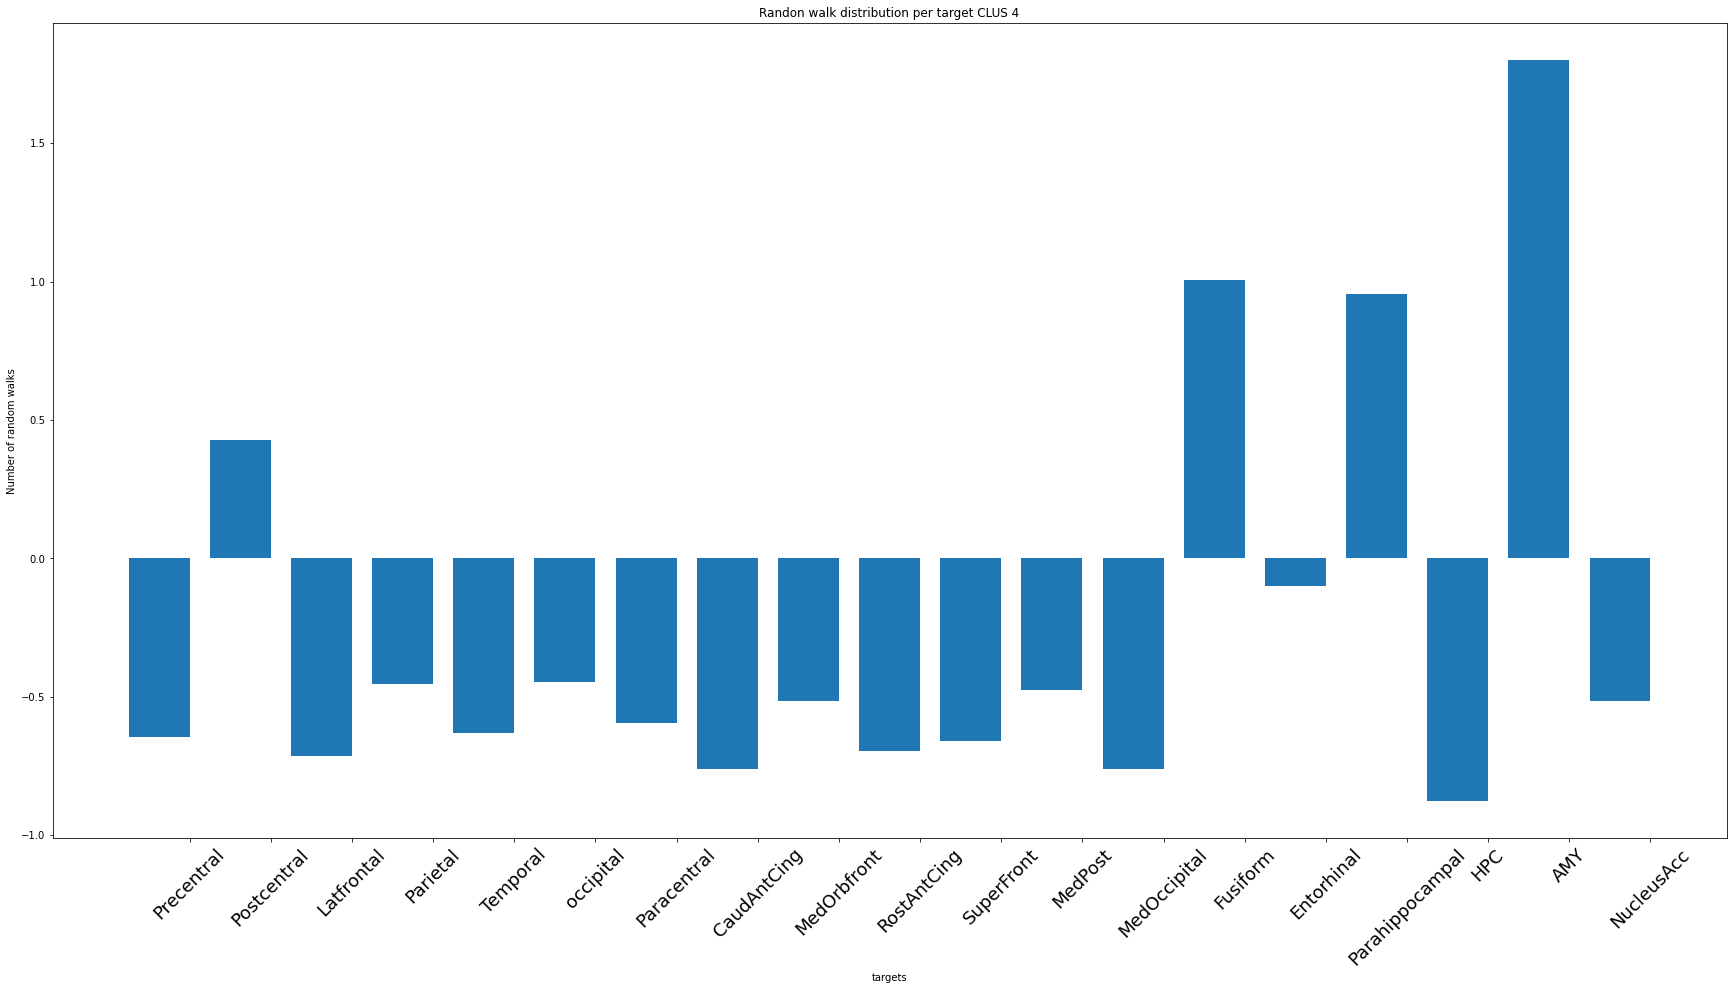

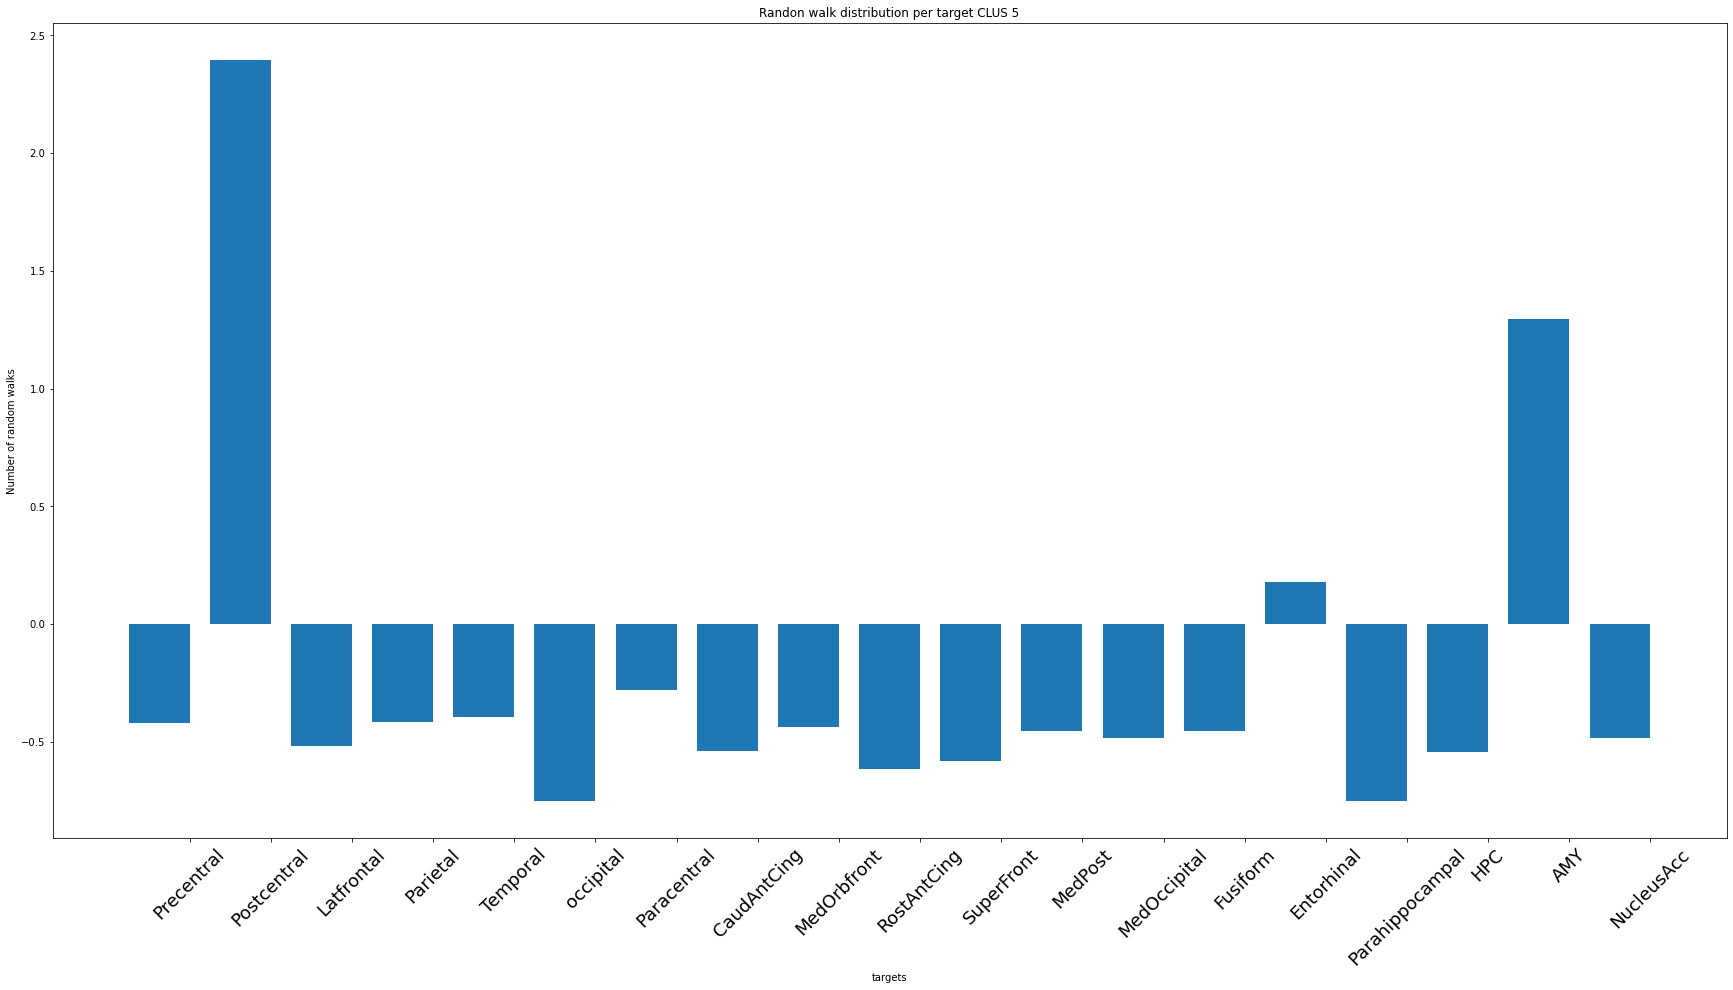

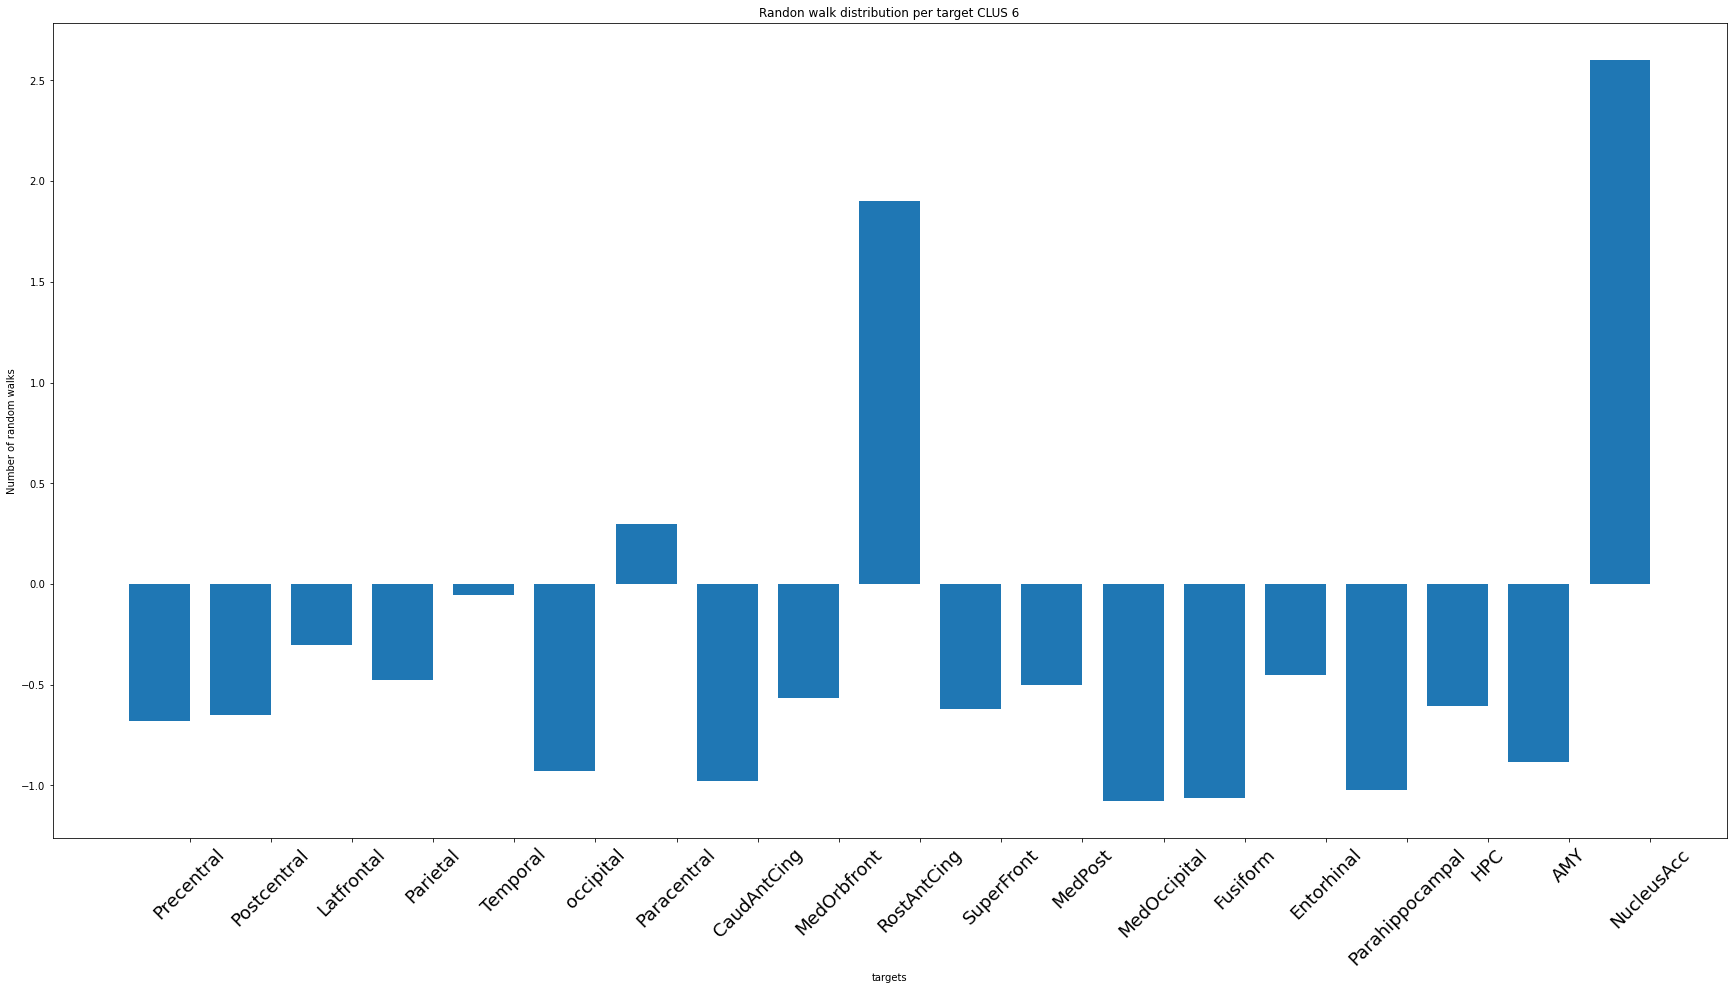

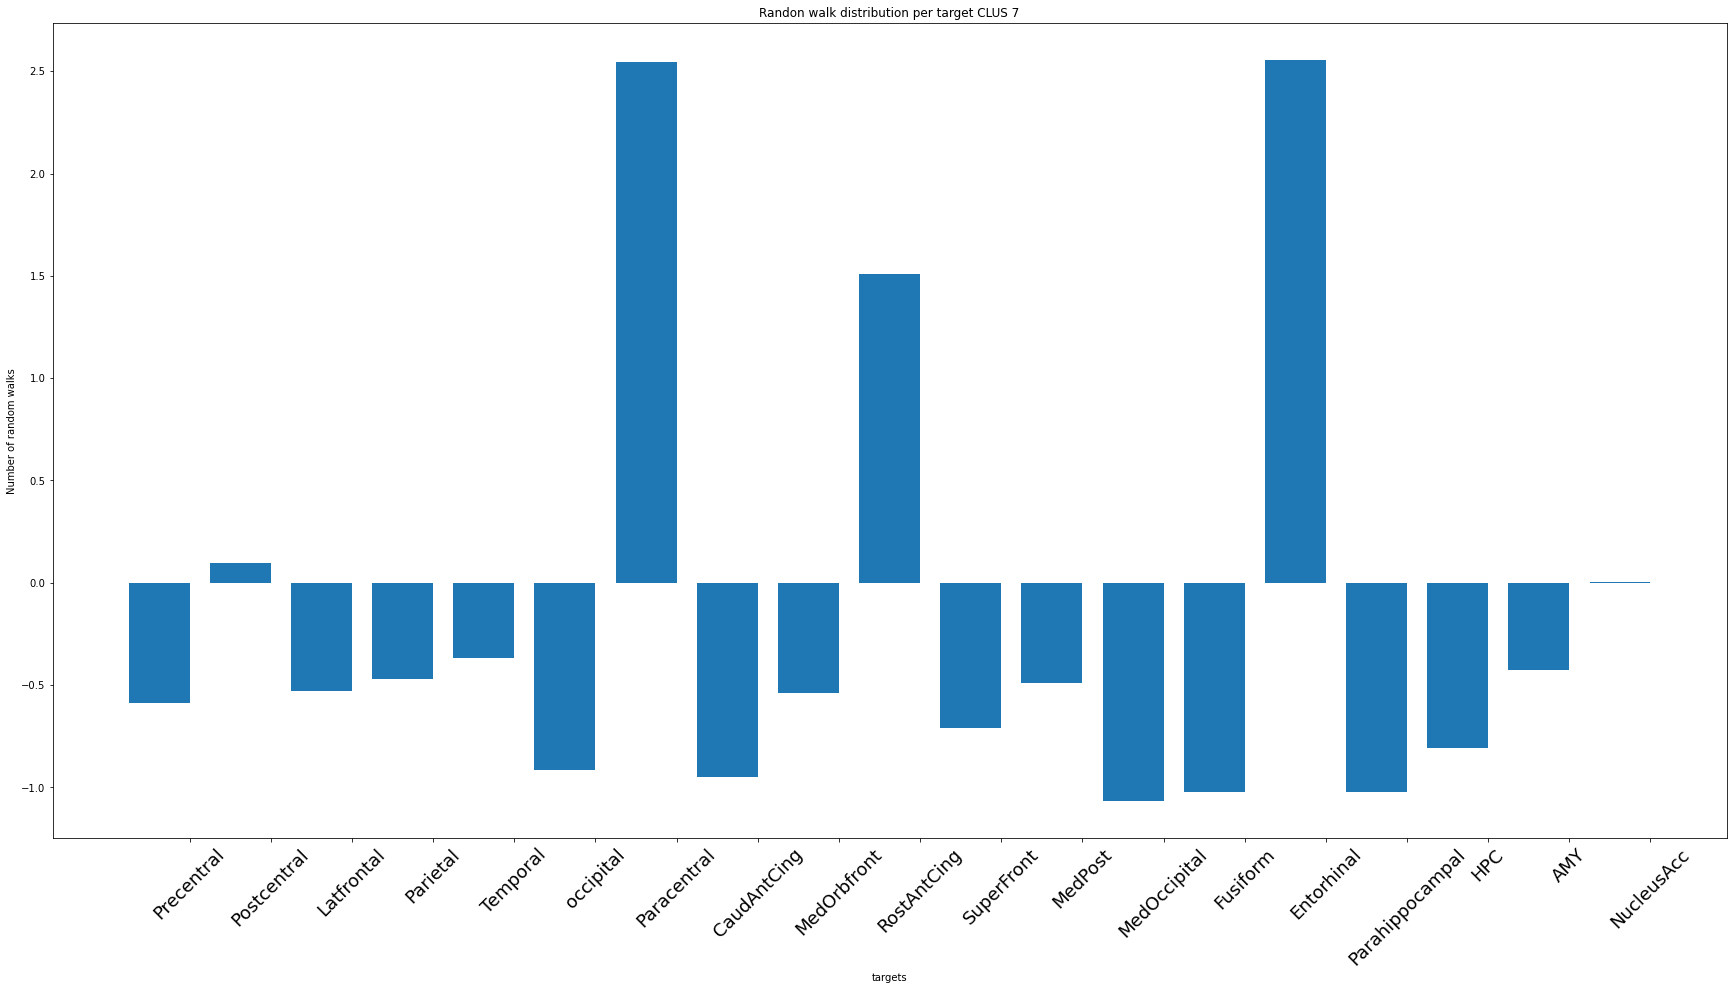

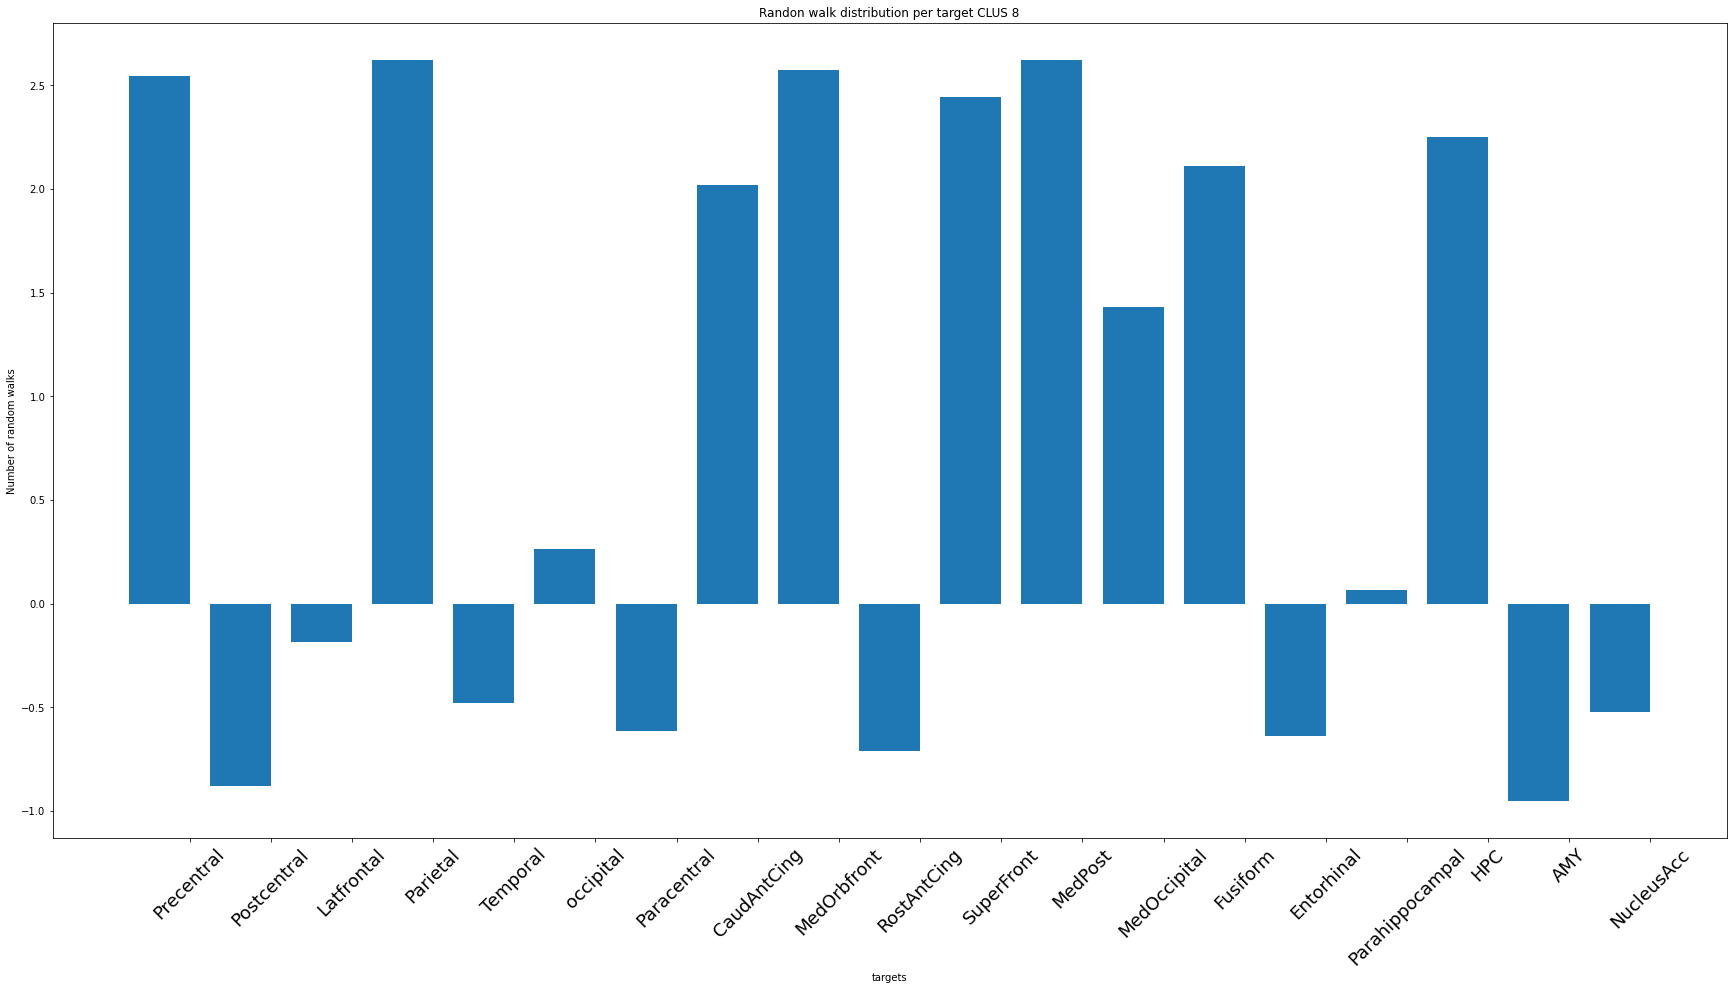

In [4]:
#Rerunning the previous cell, but for a different subject. Run this algorithm for random subjects to check the connectivity profiles of the k means clusters
subject_list = ['100408']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    
    root_dir = '/home/data/madlab/data/mri/hcp'
    #loading thalamic masks
    lh_mask = nb.load(sorted(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/seed_masks/_seedxfm_fs2dmri0/lft_thal_flirt.nii.gz')[0]))
    rh_mask = nb.load(sorted(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/seed_masks/_seedxfm_fs2dmri1/rt_thal_flirt.nii.gz')[0])) 

    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    lh_mask_data = lh_mask.get_data() #numpy array 1s and 0s
    lh_mask_data[:,0:80,:] = 0 #according to orginal script. This changes for every dataset
    #taking last slice and making 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:80,:] = 0

    
    #Creating a loop to analyze left and right hemisphere separately
    for hemi in ['0','1']:
        if hemi == '0':
            out_file = ('/home/data/madlab/data/mri/hcp/kmeans/kmeans_feature_clusters/{0}_kmeans_thallh_{1}-clus.nii.gz'.format(subject_id, n_clus))
            curr_hemi_mask = lh_mask_data
            curr_hemi_targ_files = sorted(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/targets/_pbx20/*nii.gz')) 
        else:
            out_file = ('/home/data/madlab/data/mri/hcp/kmeans/kmeans_feature_clusters/{0}_kmeans_thalrh_{1}-clus.nii.gz'.format(subject_id, n_clus))
            curr_hemi_mask = rh_mask_data
            curr_hemi_targ_files = sorted(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/' + subject_id +
                '/thal_seed/hcpprobX/targets/_pbx21/*nii.gz'))
        
        curr_hemi_mask_data_dims = curr_hemi_mask.shape
        
    
        #creates an feature by voxel array
        #Aka how often a random walk ended up from each voxel of tha thalamus to the target
        for i, curr_targ_files in enumerate(curr_hemi_targ_files):
            curr_targ = nb.load(curr_targ_files).get_data() 
            #Grabbing only the data within the thalamus (which is labeled as 1)
            curr_targ_thalonly_data = curr_targ[curr_hemi_mask > 0] 
            #reshaping our thalamus data into a 1-D numpy array
            curr_targ_thalonly_data_col = curr_targ_thalonly_data.reshape(np.int(np.sum(curr_hemi_mask)),1)
            #Now we make a voxel by target matrix where y = voxels in thalamus, and x cols is the targets
            #This will go into the kmeans algorithm
            if i == 0:
                alltarg_thalonly_img_data = curr_targ_thalonly_data_col
            else:
                alltarg_thalonly_img_data = np.concatenate((alltarg_thalonly_img_data, curr_targ_thalonly_data_col),1)

        #Now we take the 3 dimensions so we can put the data back into brain space
        rl_thal = curr_hemi_mask_data_dims[0]
        ap_thal = curr_hemi_mask_data_dims[1]
        is_thal = curr_hemi_mask_data_dims[2]
        
        #Let's run the kmeans algorithm (currently with 8 clusters)
        thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
        #Setting our out file 
        thal_kmeans_out = thal_kmeans.fit_predict(alltarg_thalonly_img_data) + 1
        #thal_kmeans_out a vector out of the thal mask between 1-8 clusters with as many numbers as voxels in thalamus
        thal_kmeans_results = curr_hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal) #making it into a vector
    
        #replacing kmeans values wherever there is a one (in thal mask) with the cluster number from the kmeans output
        i = 0
        for idx, value in enumerate(thal_kmeans_results):
            if value > 0:
                thal_kmeans_results[idx] = thal_kmeans_out[i] #i is number between 1 and 8 putting it into idx
                i += 1
        
        #reshape the column back to original n x y x n shape from vector
        thal_kmeans_results = thal_kmeans_results.reshape(curr_hemi_mask_data_dims)
        #Saving the new voxels as a .nii.gz file
        thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, hemi_affine, hemi_header) 
        #returning a string which represents the current working directory.
        kmeans_file_dir = (out_file)
        if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
            os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
        thal_kmeans_imag.to_filename(kmeans_file_dir)
        
        #calculating z-scores (including mean) for each cluster
        for x in range(len(thal_kmeans.cluster_centers_[:,0])):
        #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
            curr_thal_feature_z = []
            #running the for loop for each cluster 
            for y in range(len(thal_kmeans.cluster_centers_[0,:])):
                curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                            np.mean(thal_kmeans.cluster_centers_[:,y])) \
                            /np.std(thal_kmeans.cluster_centers_[:,y])
                curr_thal_feature_z.append(curr_thal_z)
            if x == 0:
                all_thal_features_z = curr_thal_feature_z
            else:
                all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
                

        #### Making the bar graphs ####

        #CLUSTER 1
        y1 = all_thal_features_z[0]

        x1 = np.arange(len(y1))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 1')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x1, y1, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x1)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 2
        y2 = all_thal_features_z[1]

        x2 = np.arange(len(y2))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 2')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x2, y2, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x2)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 3
        y3 = all_thal_features_z[2]

        x3 = np.arange(len(y3))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 3')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x3, y3, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x3)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 4
        y4 = all_thal_features_z[3]

        x4 = np.arange(len(y4))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 4')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x4, y4, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x4)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 5
        y5 = all_thal_features_z[4]

        x5 = np.arange(len(y5))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 5')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x5, y5, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x5)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 6
        y6 = all_thal_features_z[5]

        x6 = np.arange(len(y6))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 6')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x6, y6, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x6)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 7
        y7 = all_thal_features_z[6]

        x7 = np.arange(len(y7))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 7')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x7, y7, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x7)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()

        #CLUSTER 8
        y8 = all_thal_features_z[7]

        x8 = np.arange(len(y8))
        width = 0.25

        fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(30,15))
        plt.title('Randon walk distribution per target CLUS 8')
        plt.xlabel('targets')
        plt.ylabel('Number of random walks')

        axes.bar(x8, y8, width=-3.*width, align='edge', label="Algorithm 1")
        axes.set_xticks(x8)
        axes.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'occipital',
                              'Paracentral', 'CaudAntCing','MedOrbfront', 'RostAntCing', 'SuperFront',
                              'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 'Parahippocampal', 'HPC', 
                              'AMY', 'NucleusAcc'], 
                              fontsize=18, rotation=45)
        plt.show()
        

        

******************************************************************************************************
******************************************************************************************************
******************************************************************************************************

# Do this for 10 more subjects

******************************************************************************************************
******************************************************************************************************
******************************************************************************************************

In [ ]:
###########################OLD############################################

In [ ]:
#plotting.plot_img(lh_mask_data)

**Subject 100307**

In [ ]:
subject_list = ['100307']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8

    root_dir = '/home/data/madlab/data/mri/hcp'
    
    #NEED TO MAKE THESE PR
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrack/hcp_thal_mask/'  + subject_id + '/thal_seed/hcpprobX/thal_mask/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0])
    rh_mask = nb.load(glob(root_dir + '/probtrack/hcp_thal_mask/'  + subject_id + 
                           '/thal_seed/hcpprobX/thal_mask/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
   
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:80,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:80,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data

    
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    #lh_targ_files = glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask_january/'+ subject_id +'/thal_seed/hcpprobX/targets/_pbx20/*nii.gz'.format(subject_id)) 
    rh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrack/thalamus_25ksamp_avoidmask_january/' + '{0}/thal_seed/hcpprobX/targets/_pbx21/*nii.gz'.format(subject_id)) 
    
    
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/hcp_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

In [ ]:
lh_targ_files

In [ ]:
fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
subject_list = ['100307']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8

    root_dir = '/home/data/madlab/data/mri/hcp'
    
    #NEED TO MAKE THESE PR
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrack/thalamus_25ksamp_avoidmask' 
                + subject_id + '/thal_seed/hcpprobX/'
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) 
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
   
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:80,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:80,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrck/thalamus_25samp_avoidmask/' +
                '{0}/thal_seed/hcpprobX/targets/_pbx20/*nii.gz'.format(subject_id)) 
    rh_targ_files = glob('/home/data/madlab/data/mri/hcp/probtrck/thalamus_25samp_avoidmask/' +
                '{0}/thal_seed/hcpprobX/targets/_pbx21/*nii.gz'.format(subject_id)) 

    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
print(all_thal_features_z[[5]])

In [ ]:
all_thal_features_z_1067 = [1.8865081, -0.25020918, -0.64991844, -0.5367271, -0.99659,
                              2.6272006, -0.65121686, -0.45681167, 0.10836264, -1.0291086, -0.96729654,
                              -0.73409945, -0.5107393, -0.08092461, -0.32473305, -0.25589103, -0.36399293,
                              -0.41195437, -0.36264867, -0.7248616]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1067, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1005**

In [ ]:
subject_list = ['1005']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:80,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:80,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
print(all_thal_features_z[[2]])

In [ ]:
all_thal_features_z_1005 = [0.16668117, -0.7436653, -0.58757484, -0.3192579, -0.5118745,
                              2.627344, -0.65432876, -1.5402926, 2.1895578, -1.1785033, -1.1303425,
                              -0.6468146, -0.55271035, -0.4201458, -0.4014152, -0.34837717,
                              -0.6643454, -0.9182006, -0.8273582, -0.5448167]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1005, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1007**

In [ ]:
subject_list = ['1007']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:80,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:80,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
print(all_thal_features_z[[1]])

In [ ]:
all_thal_features_z_1007 = [-0.25001296, -0.33079585, -0.239428, -0.49327752,
                              -0.4248419, 0.58118474, -0.50075686, -0.24736731,
                              0.35035443, -0.47365025, -0.7242383, -0.19336702, 
                              0.1045007, -0.45908687, -0.29293296, -0.29552928,
                              -0.40280017, -0.28522432, -0.38081285, -0.40990993]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1007, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1027**

In [ ]:
subject_list = ['1027']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:80,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:80,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
print(all_thal_features_z[[1]])

In [ ]:
all_thal_features_z_1027 = [-0.6288464, -0.30373445, -0.17406102, 0.12447993, -0.6728202,
                              -0.2793646, -0.59623194, -0.2737399, -0.5689539, -0.9163755,
                              -0.46653625, -0.47232077, -0.77391064, -0.02602504, 2.5999827,
                              2.5917237, -0.38971254, -0.30250898, 0.65668553, -0.6972402]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1027, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1057**

In [ ]:
subject_list = ['1057']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
print(all_thal_features_z[[5]])

In [ ]:
all_thal_features_z_1057 = [0.9168984, -0.3349994, -0.7017681, -0.4711401, -0.44232786,
                              2.6424153, -0.5396621, -0.61936176, -0.04689944, -0.93862176,
                              -0.6164822, -0.49912006, -1.03836, -0.47297886, -0.26653963,
                              -0.28105602, -0.4353687, -0.4350432, -0.77059317, -0.74518645]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1057, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 101006**

In [ ]:
subject_list = ['101006']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
print(all_thal_features_z[[2]])

In [ ]:
all_thal_features_z_1070 = [0.22547755, 0.06083832, -1.1662128, -1.0106962, -0.61848176,
                              -0.50340724, -0.38631383, -0.65481615, -0.74279773, -0.807022,
                              1.1592464, -0.30747348, 2.4293196, -0.89199275, -0.64217633,
                              -0.58279246, -0.5271472, -0.40477288, -0.826307, 2.6237695]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1070, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**Subject 1025** 

In [ ]:
subject_list = ['1025']
for subject_id in subject_list:
  # Number of clusters created during kmeans algorithm 
    n_clus = 8
    from sklearn.cluster import KMeans
    import nibabel as nb
    from glob import glob
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    root_dir = '/home/data/madlab/data/mri/emu/dwi'
    #loading masks
    lh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask0/lft_thal.nii.gz'.format(subject_id))[0]) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_mask = nb.load(glob(root_dir + '/probtrakx_thal_v2/' + subject_id +
                '/emuprobX/thal_mask/_subject_id_{0}/_thal_seed_mask1/rt_thal.nii.gz'.format(subject_id))[0])
    #using raster(io) and affine to get the matrix (2D array) for our masks
    hemi_affine = lh_mask.affine
    hemi_header = lh_mask.header
    #merging the bilateral masks
    lh_mask_data = lh_mask.get_data()
    lh_mask_data[:,0:60,:] = 0
    rh_mask_data = rh_mask.get_data()
    rh_mask_data[:,0:60,:] = 0
    hemi_mask = lh_mask_data + rh_mask_data
    # Replace posterior slice values with 0
    #shape of the hemi_mask
    hemi_dims = hemi_mask.shape
    #defining target seeds path
    #".format" = replaces the subject_id in the "{0}"
    lh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx20/*nii.gz'.format(subject_id)) #"_subject_id_" change made on 4/12/20 by MVRN
    rh_targ_files = glob('/home/data/madlab/data/mri/emu/dwi/probtrakx_thal_v2/' +
                '{0}/emuprobX/targets/_subject_id_{0}/_pbx21/*nii.gz'.format(subject_id))
    #merging and loading target files (producing an array of tuples!)
    bilat_targ_files = zip(lh_targ_files, rh_targ_files)
    targ_affine = nb.load(lh_targ_files[0]).affine
    #general info about the image (content, image buffer, spacing, etc)
    targ_header = nb.load(lh_targ_files[0]).header
    #loading masked target seeds and turning 1D array into a matrix for non-zero valued only
    #(hemi_mask x # of targ_files)
    input_thal_array = np.concatenate([(nb.load(lh).get_data()+nb.load(rh).get_data())[hemi_mask>0].reshape(np.sum(hemi_mask), 1) \
                                       for lh, rh in bilat_targ_files], axis = 1)

    rl_thal = hemi_dims[0]
    ap_thal = hemi_dims[1]
    is_thal = hemi_dims[2]
    
    thal_kmeans = KMeans(init = 'k-means++', n_clusters=n_clus, n_init=10)
    thal_kmeans_out = thal_kmeans.fit_predict(input_thal_array) + 1
    #making a vector out of the thal mask
    thal_kmeans_results = hemi_mask.copy().reshape(rl_thal*ap_thal*is_thal)
    
    #replacing kmeans values wherever there is a one (in thal mask)
    i = 0
    for idx, value in enumerate(thal_kmeans_results):
        if value > 0:
            thal_kmeans_results[idx] = thal_kmeans_out[i]
            i += 1
        
    #reshape the column back to original n x y x n shape
    thal_kmeans_results = thal_kmeans_results.reshape(hemi_dims)
    #Saving the new voxels as a .nii.gz file
    thal_kmeans_imag = nb.Nifti1Image(thal_kmeans_results, targ_affine, targ_header) 
    #returning a string which represents the current working directory.
    kmeans_filename = '{0}/emu_bilat_limbicthal_kmeans_{1}-clus.nii.gz'.format(subject_id,n_clus)
    kmeans_file_dir = os.path.abspath(kmeans_filename)
    if not os.path.isdir(os.getcwd() + '/{0}'.format(subject_id)):
        os.mkdir(os.getcwd() + '/{0}'.format(subject_id))
    thal_kmeans_imag.to_filename(kmeans_file_dir)
    
    #calculating z-scores (including mean) for each cluster
    for x in range(len(thal_kmeans.cluster_centers_[:,0])):
    #subtracting the cluster mean from the data points in the kmeans cluster & dividing by SD
        curr_thal_feature_z = []
        #running the for loop for each cluster 
        for y in range(len(thal_kmeans.cluster_centers_[0,:])):
            curr_thal_z = (thal_kmeans.cluster_centers_[x,y] - 
                           np.mean(thal_kmeans.cluster_centers_[:,y])) \
                           /np.std(thal_kmeans.cluster_centers_[:,y])
            curr_thal_feature_z.append(curr_thal_z)
        if x == 0:
            all_thal_features_z = curr_thal_feature_z
        else:
            all_thal_features_z = np.vstack((all_thal_features_z, curr_thal_feature_z))
            

fig, axes = plt.subplots(nrows=8, figsize=(30,65))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.ravel()

x = np.arange(20) #np.arange must be the same length as the number of clusters in the data. 

y1 = all_thal_features_z[0]
y2 = all_thal_features_z[1]
y3 = all_thal_features_z[2]
y4 = all_thal_features_z[3]
y5 = all_thal_features_z[4]
y6 = all_thal_features_z[5]
y7 = all_thal_features_z[6]
y8 = all_thal_features_z[7]

width = 0.25

ax1.bar(x, y1, (width+0.70))
ax1.set_xticks(x + width)
ax1.grid(False)
ax1.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax2.bar(x, y2, (width+0.70))
ax2.set_xticks(x + width)
ax2.grid(False)
ax2.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax3.bar(x, y3, (width+0.70))
ax3.set_xticks(x + width)
ax3.grid(False)
ax3.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax4.bar(x, y4, (width+0.70))
ax4.set_xticks(x + width)
ax4.grid(False)
ax4.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax5.bar(x, y5, (width+0.70))
ax5.set_xticks(x + width)
ax5.grid(False)
ax5.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax6.bar(x, y6, (width+0.70))
ax6.set_xticks(x + width)
ax6.grid(False)
ax6.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax7.bar(x, y7, (width+0.70))
ax7.set_xticks(x + width)
ax7.grid(False)
ax7.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)

ax8.bar(x, y8, (width+0.70))
ax8.set_xticks(x + width)
ax8.grid(False)
ax8.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippocampal', 'HPC', 'AMY', 'NucleusAcc'], fontsize=18, rotation=45)


plt.show()

In [ ]:
print(all_thal_features_z[[1]])

In [ ]:
all_thal_features_z_1025 = [-0.46135876, -0.34748942, 0.33832175, -0.48265627, -0.41765478,
                              -0.29014364, -0.47266763, -0.18013981, -0.47626647, -1.0550807, -0.54965895,
                              -0.14967133, -0.6984921, -0.4046384, 2.6073556, 2.5888143, -0.65255636,
                              -0.38128266, -0.9097497, -0.90569204]

x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1025, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)
plt.show()

**All Midline_thal Clusters**

In [ ]:
#1067
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1067, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1005
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1005, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1007
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1007, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1027
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1027, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1057
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1057, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1070
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1070, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

#1025
x = range(20)

plt.figure(figsize=(26, 10))  # width:26, height:10
ax = plt.subplot(111)
ax.bar(x, all_thal_features_z_1025, width=0.8, color='g')
ax.set_xticks(x)
ax.set_xticklabels(['Precentral', 'Postcentral', 'Latfrontal', 'Parietal', 'Temporal', 'Insula', 
                     'LatOccipital', 'Paracentral', 'CaudAntCing',
                     'MedOrbfront', 'RostAntCing', 'SuperFront',
                     'MedPost', 'MedOccipital', 'Fusiform', 'Entorhinal', 
                     'Parahippo', 'HPC', 'AMY', 'NuclAcc'], fontsize=18, rotation=45)

plt.show()